# rolling_correlations.ipynb
Functions to examine rolling correlations between device sensor outputs.
Author: – Jon Clucas, 2017 jon.clucas@childmind.org
© 2017, Child Mind Institute, Apache v2.0 License

setup:

In [71]:
%matplotlib inline
from annotate_range import annotation_line
from chart_data import write_csv
from config import organized_dir, placement_dir
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from plot_normalized_vector_lengths import baseshift_and_renormalize
import json, numpy as np, os, pandas as pd, matplotlib.pyplot as plt
with open(os.path.join('./line_charts/device_colors.json')) as fp:
    color_key = json.load(fp)
pd.set_option('mode.use_inf_as_null', True)

define functions:

In [75]:
def linechart(df, plot_label, plot_person):
    """
    Function to build a linechart and export a PNG and an SVG of the image.
    
    Parameters
    ----------
    df : pandas dataframe
        dataframe to plot
        
    plot_label : string
        plot title
        
    plot_person : string
        wearer (for annotations)
        
    Returns
    -------
    None
    
    Outputs
    -------
    inline plot
    """
    start = min(df.index.values)
    stop = max(df.index.values)
    w_log = pd.read_csv(os.path.join(placement_dir, 'wearable_log.csv'),
            parse_dates={'start':['start date', 'start time'], 'stop':[
            'end date', 'end time']})
    w_log.dropna(inplace=True)
    w_log['start'] = pd.to_datetime(w_log.start, errors="coerce")
    w_log['stop'] = pd.to_datetime(w_log.stop, errors="coerce")
    print("Plotting...")
    print(plot_label)
    svg_out = os.path.join(organized_dir, 'accelerometer', "_".join([
              'normalized_vector_length', '.'.join(['_'.join(plot_label.split(
              ' ')), 'svg'])]))
    png_out = ''.join([svg_out.strip('svg'), 'png'])
    fig = plt.figure(figsize=(10, 8), dpi=75)
    plt.rcParams['agg.path.chunksize'] = 10000
    ax = fig.add_subplot(111)
    ax.set_ylabel('unit cube normalized vector length')
    annotations_a = {}
    annotations_b = {}
    annotation_y = 0.04
    plot_log = w_log.loc[(w_log['wearer'] == plot_person) & (w_log['start'] >= 
                         start) & (w_log['stop'] <= stop)].copy()
    for row in plot_log.itertuples():
        if row[4] not in annotations_a:
            annotations_a[row[4]] = row[1] if row[1] >= start else start
            annotations_b[row[4]] = row[2] if row[2] <= stop else stop
    esses = []
    for device in list(df.columns):
        d2 = device[25:]
        plot_line = df[[device]].dropna()
        esses.append(pd.Series(plot_line.iloc[:,0], name=d2, index=
                     plot_line.index))
        if "GENEActiv" in device:
            label = "GENEActiv"
        elif device == "Actigraph":
            label = "ActiGraph"
        else:
            label = d2
        """
        if device == "Wavelet":
            ax.plot_date(x=plot_line.index, y=plot_line, color=color_key[
                         device], alpha=0.5, label=label, marker="o",
                         linestyle="None")
        else:
        """
        ax.plot_date(x=plot_line.index, y=plot_line, color=color_key[
                         d2], alpha=0.5, label=label, marker="", linestyle=
                         "solid")
        ax.legend(loc='best', fancybox=True, framealpha=0.5)
    for annotation in annotations_a:
        try:
            annotation_line(ax, annotations_a[annotation], annotations_b[
                            annotation], annotation, annotation_y)
            annotation_y += 0.08
        except:
            print(annotation)
    ax.set_ylim([0, 1])
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
    plt.suptitle(plot_label)
    plt.xticks(rotation=65)
    plt.show()
    
def df_two_devices(devices, sensor, start, stop):
    """
    Function to calculate rolling correlations between two sensor data streams.
    
    Parameters
    ----------
    devices : list of strings (len 2)
        each string is the name of one of the two devices to compare
        
    sensor : string
        the sensor to compare
        
    start : datetime
        beginning of time to compare
        
    stop : datetime
        end of time to compare
        
    Returns
    -------
    df : pandas dataframe
        merged dataframe with a column per device
    """
    if sensor == 'accelerometer':
        suffix = '_normalized_unit.csv'
    else:
        suffix = '.csv'
    s0 = pd.read_csv(os.path.join(organized_dir, sensor, ''.join([devices[0],
         suffix])), usecols=['Timestamp', 'normalized_vector_length'],
         parse_dates=['Timestamp'], infer_datetime_format=True)
    s0 = s0.loc[(s0['Timestamp'] >= start) & (s0['Timestamp'] <= stop)].copy()
    s1 = pd.read_csv(os.path.join(organized_dir, sensor, ''.join([devices[1],
         suffix])), usecols=['Timestamp', 'normalized_vector_length'],
         parse_dates=['Timestamp'], infer_datetime_format=True)
    s1 = s1.loc[(s1['Timestamp'] >= start) & (s1['Timestamp'] <= stop)].copy()
    # m0, m1 = only_matching_ts_points(s0, s1, 'second')
    s0 = baseshift_and_renormalize(s0)
    s1 = baseshift_and_renormalize(s1)
    s1[['Timestamp']] = s1.Timestamp.apply(lambda x: x - timedelta(microseconds
                        =1000))
    s0.set_index('Timestamp', inplace=True)
    s1.set_index('Timestamp', inplace=True)
    df = s0.merge(s1, left_index=True, right_index=True, suffixes=(''.join([
         '_', devices[0]]), ''.join(['_', devices[1]])))
    return(df)

In [12]:
df = df_two_devices(['GENEActiv_pink', 'Actigraph'], 'accelerometer',  datetime(2017, 4, 6, 15, 45), datetime(2017, 4,
     7, 14, 8))

In [13]:
pdcorr = df.corr(method='pearson')
print(pdcorr)

pdcorr = df.corr(method='kendall')
print(pdcorr)

pdcorr = df.corr(method='spearman')
print(pdcorr)

                                         normalized_vector_length_GENEActiv_pink  \
normalized_vector_length_GENEActiv_pink                                 1.000000   
normalized_vector_length_Actigraph                                      0.253536   

                                         normalized_vector_length_Actigraph  
normalized_vector_length_GENEActiv_pink                            0.253536  
normalized_vector_length_Actigraph                                 1.000000  
                                         normalized_vector_length_GENEActiv_pink  \
normalized_vector_length_GENEActiv_pink                                 1.000000   
normalized_vector_length_Actigraph                                     -0.122574   

                                         normalized_vector_length_Actigraph  
normalized_vector_length_GENEActiv_pink                           -0.122574  
normalized_vector_length_Actigraph                                 1.000000  
                          

In [35]:
start = datetime(2017, 4, 7, 7, 16)
stop = start + timedelta(seconds=30)
sliced_df = df.loc[(df.index >= start) & (df.index <= stop)].copy()
print(sliced_df.corr(method='pearson'))

                                         normalized_vector_length_GENEActiv_pink  \
normalized_vector_length_GENEActiv_pink                                 1.000000   
normalized_vector_length_Actigraph                                      0.040786   

                                         normalized_vector_length_Actigraph  
normalized_vector_length_GENEActiv_pink                            0.040786  
normalized_vector_length_Actigraph                                 1.000000  


Plotting...
ActiGraph vs GENEActiv


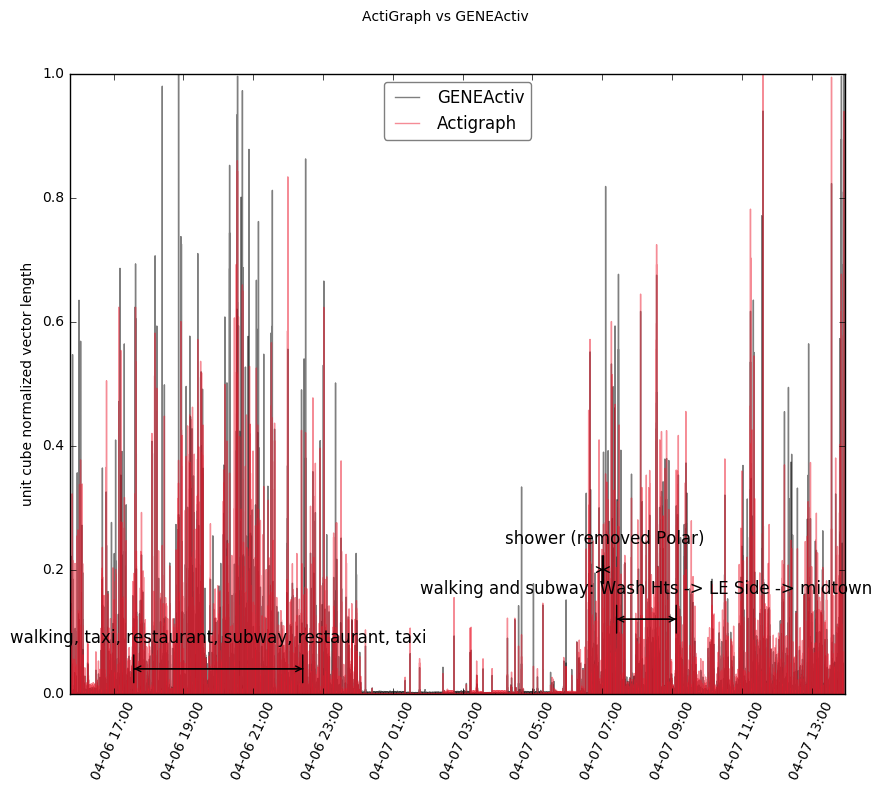

In [76]:
linechart(df, "ActiGraph vs GENEActiv", "Arno")

In [44]:
rcorr = df.rolling(window=180, center=True).corr()
print(rcorr.dropna().mean())

Timestamp                                2017-04-06 15:45:01.516  \
normalized_vector_length_GENEActiv_pink                 0.462925   
normalized_vector_length_Actigraph                      0.462925   

Timestamp                                2017-04-06 15:45:01.533  \
normalized_vector_length_GENEActiv_pink                 0.459081   
normalized_vector_length_Actigraph                      0.459081   

Timestamp                                2017-04-06 15:45:01.549  \
normalized_vector_length_GENEActiv_pink                 0.456053   
normalized_vector_length_Actigraph                      0.456053   

Timestamp                                2017-04-06 15:45:01.566  \
normalized_vector_length_GENEActiv_pink                 0.452957   
normalized_vector_length_Actigraph                      0.452957   

Timestamp                                2017-04-06 15:45:01.583  \
normalized_vector_length_GENEActiv_pink                 0.454345   
normalized_vector_length_Actigraph          

Plotting...
15:45:00–15:45:30


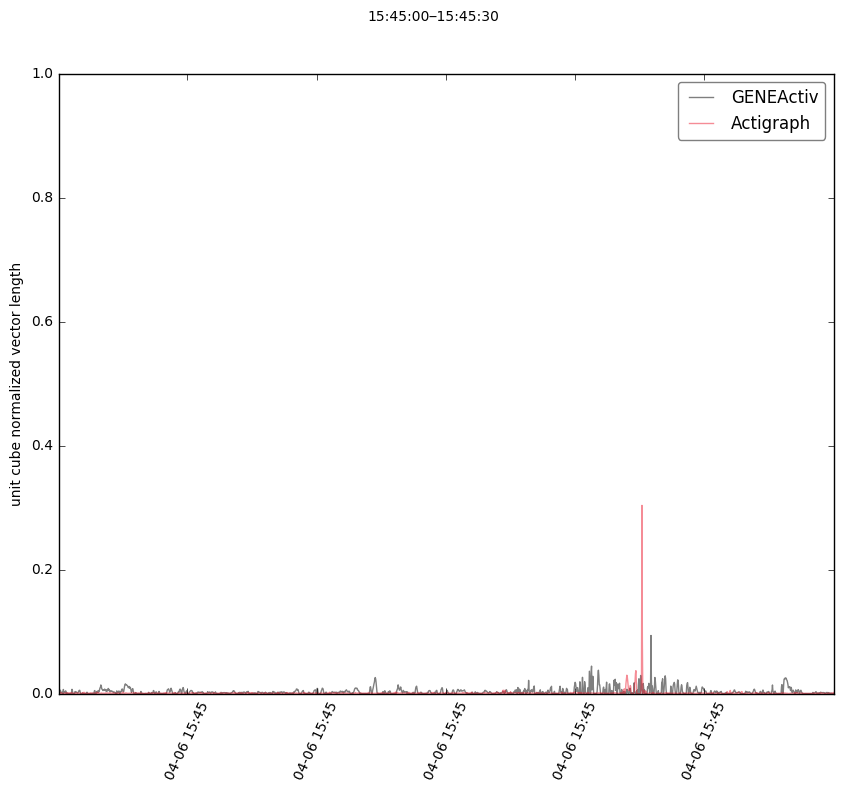

Plotting...
15:45:30–15:46:00


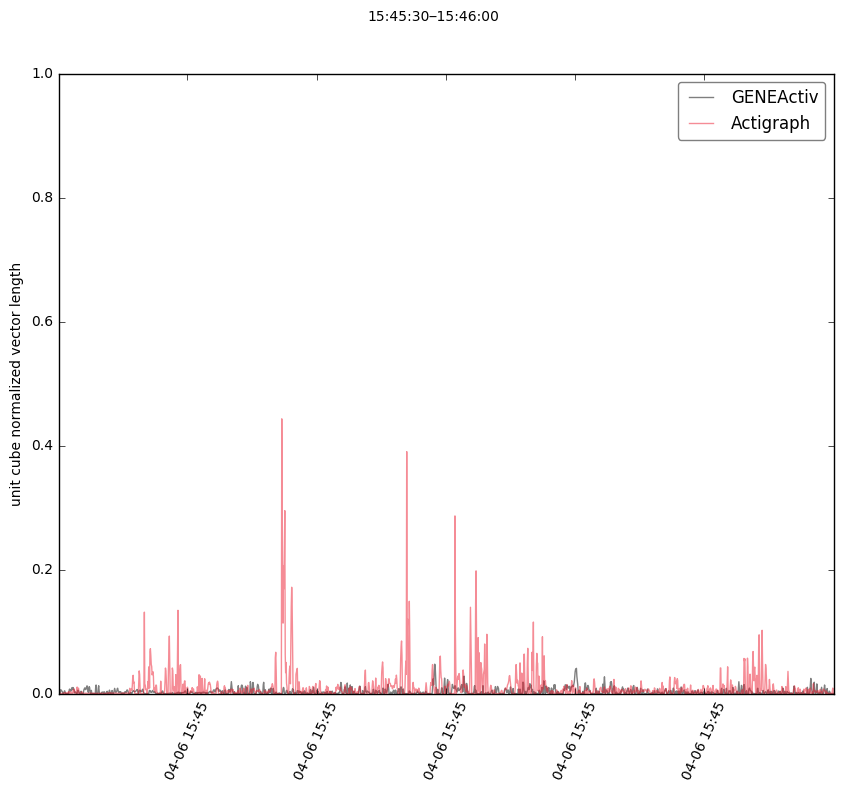

Plotting...
15:46:00–15:46:30


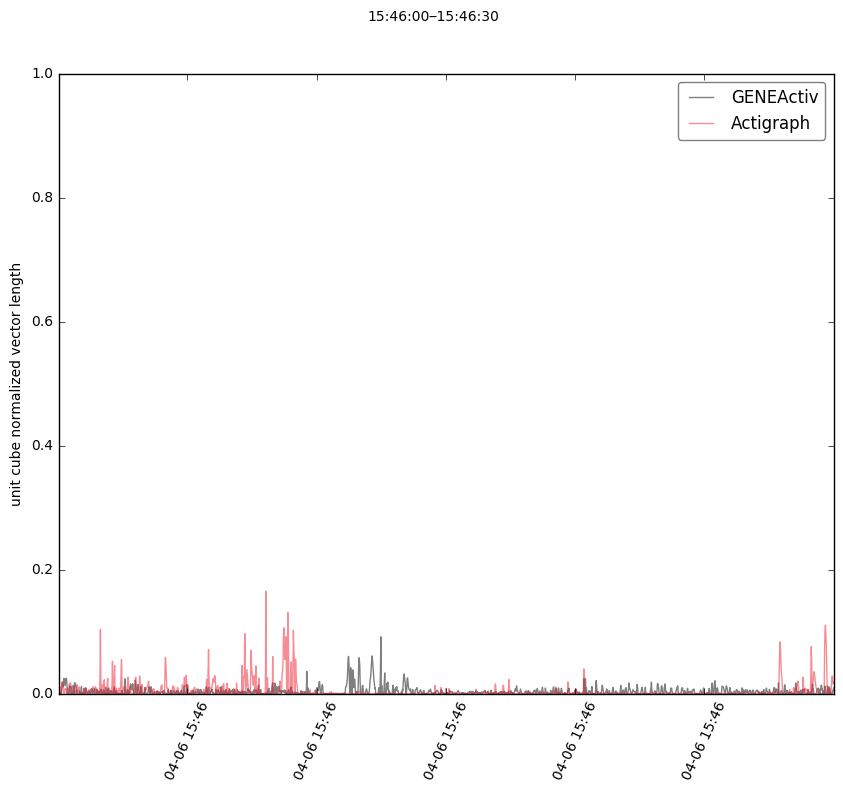

Plotting...
15:46:30–15:47:00


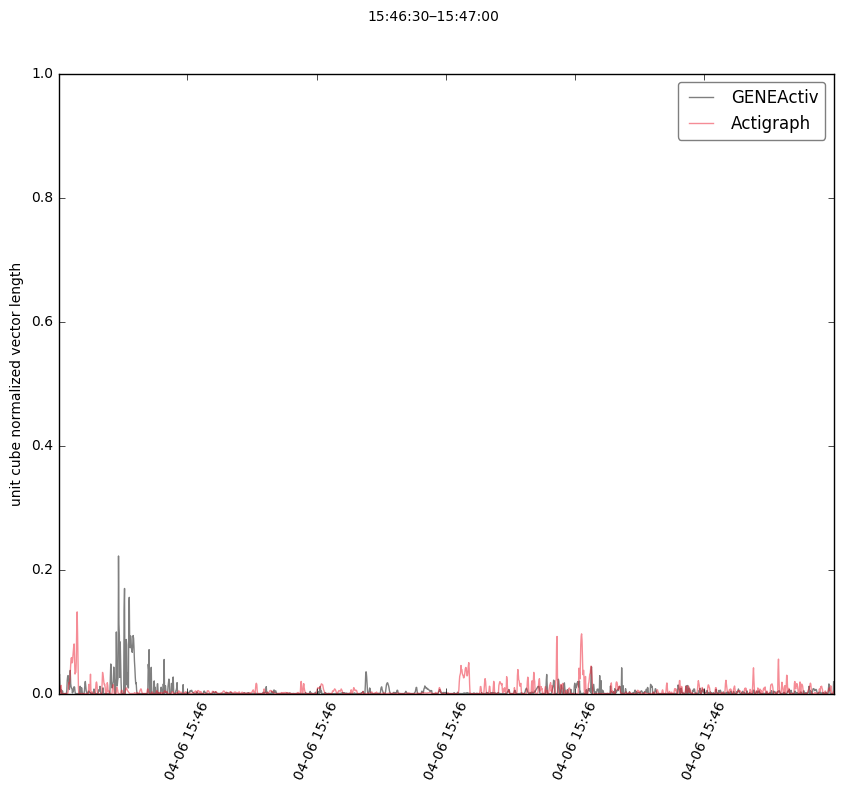

Plotting...
15:47:00–15:47:30


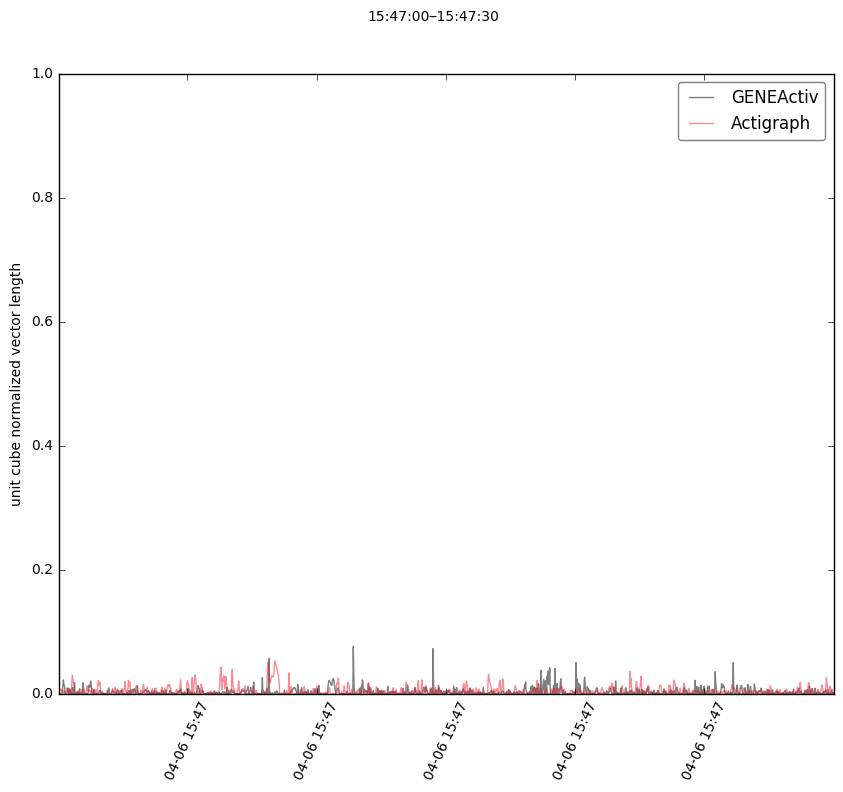

Plotting...
15:47:30–15:48:00


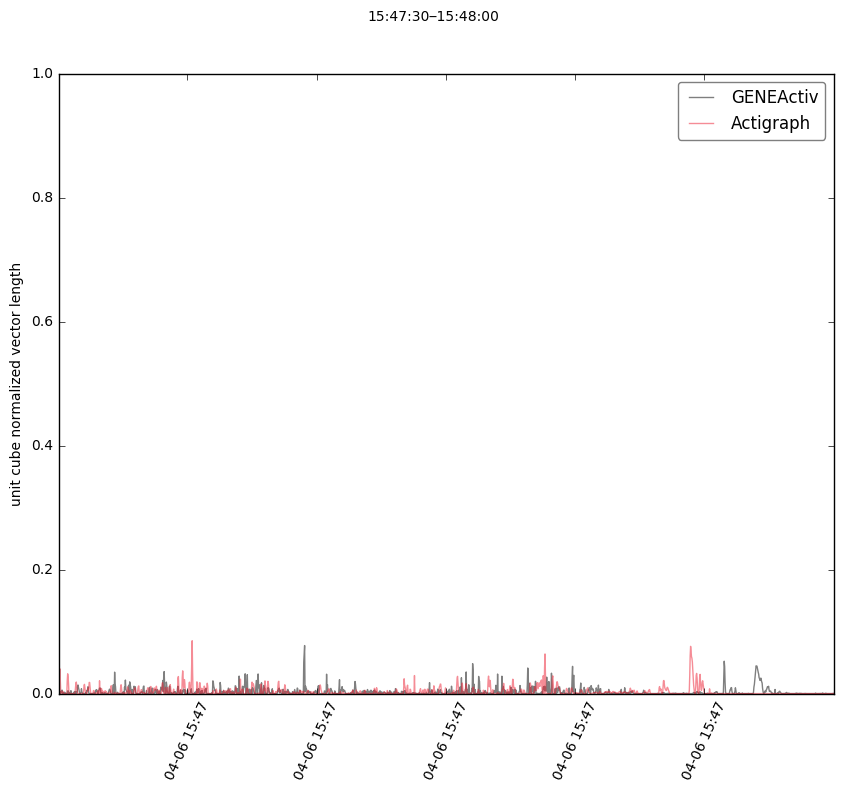

Plotting...
15:48:00–15:48:30


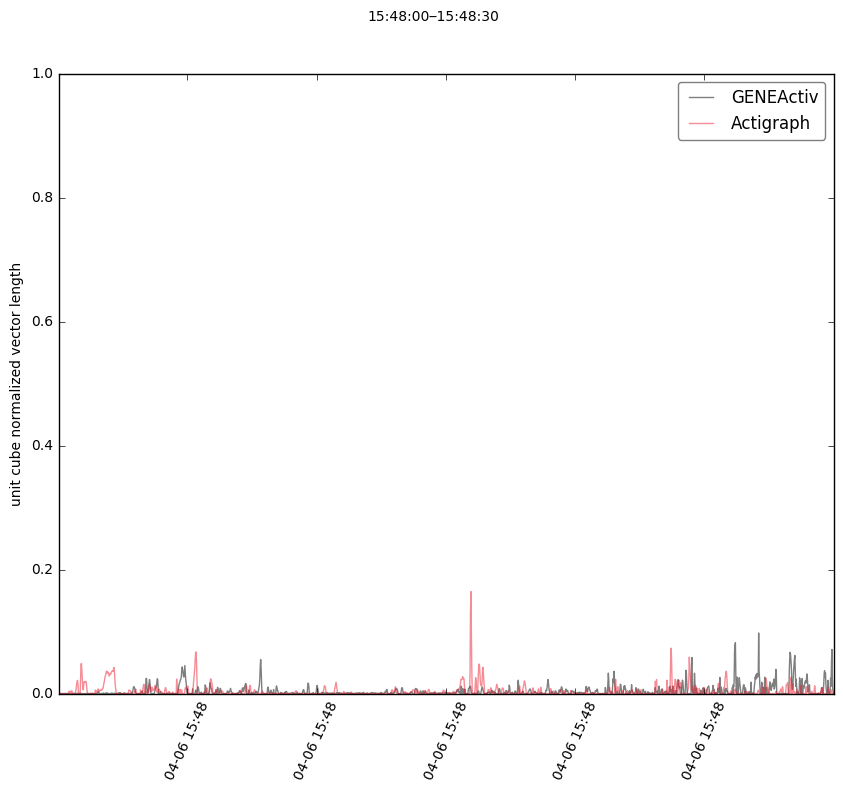

Plotting...
15:48:30–15:49:00


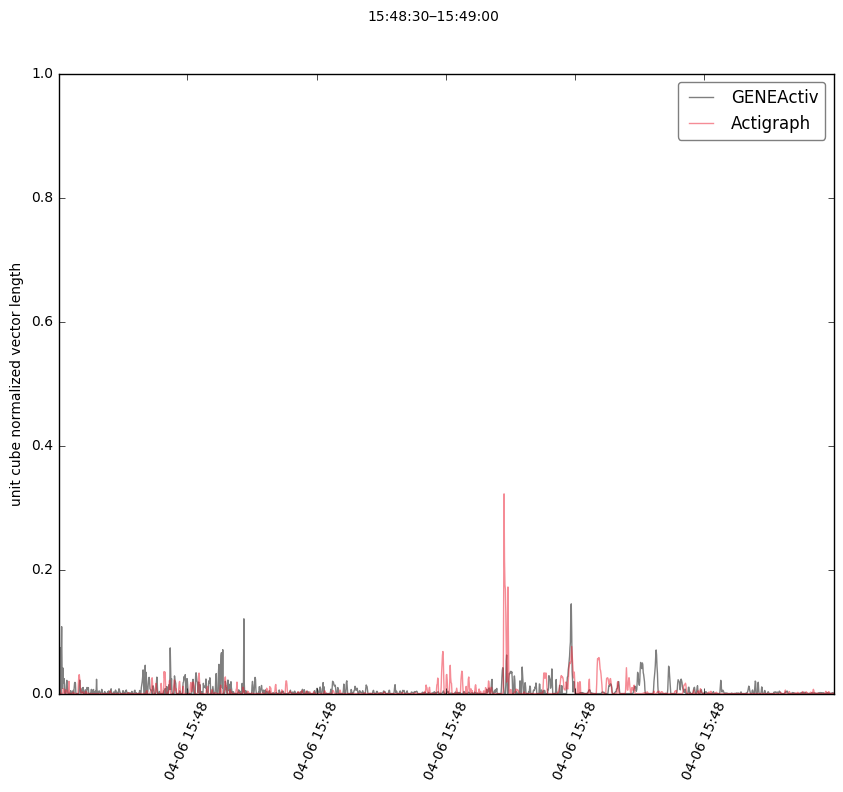

Plotting...
15:49:00–15:49:30


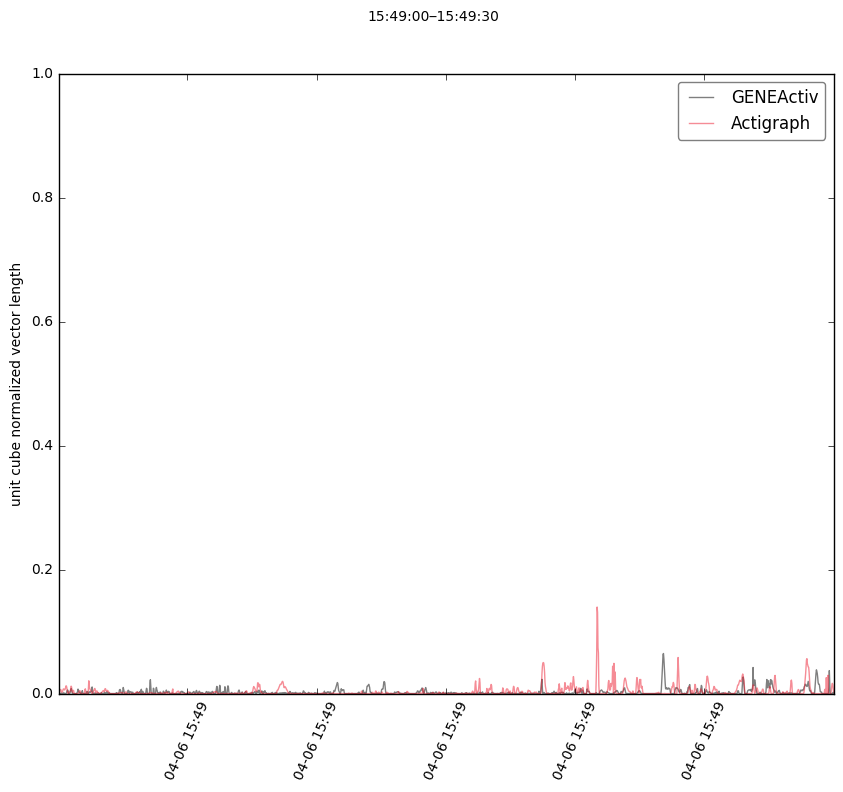

Plotting...
15:49:30–15:50:00


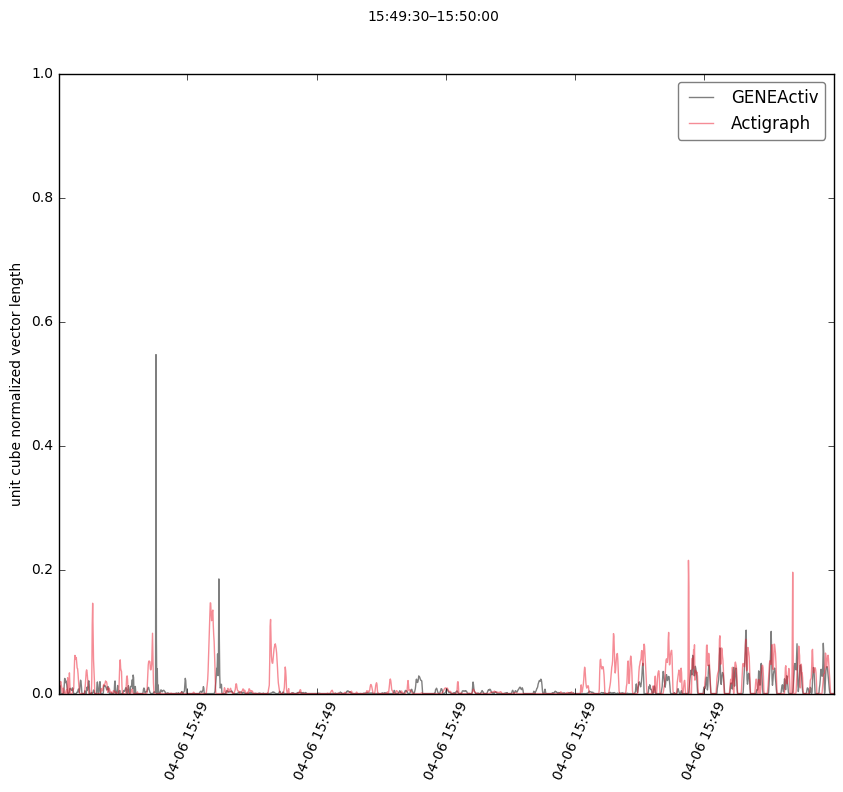

Plotting...
15:50:00–15:50:30


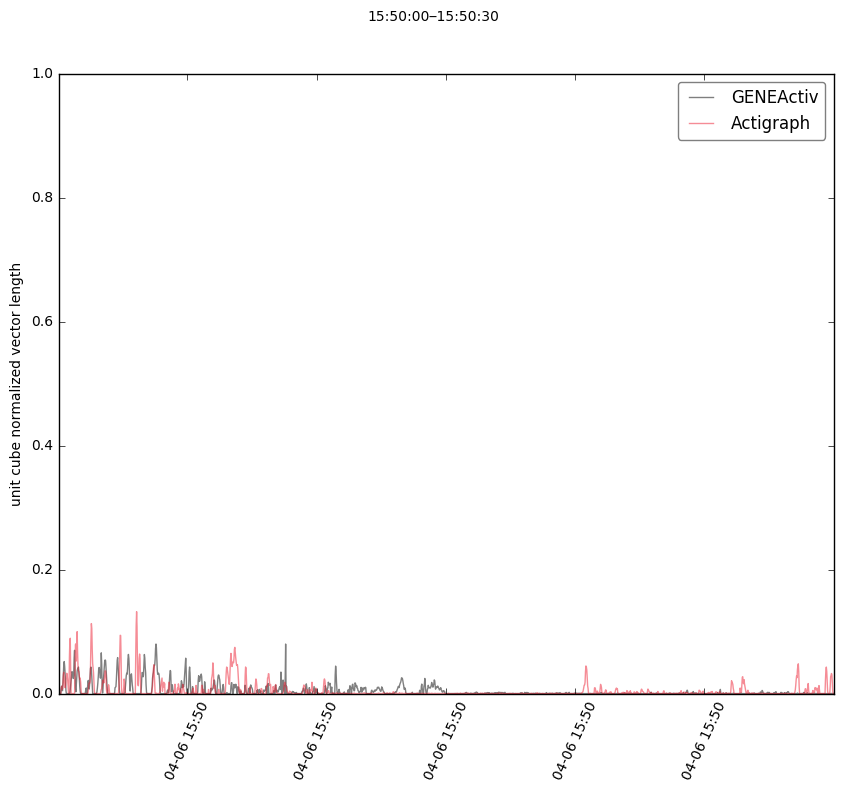

Plotting...
15:50:30–15:51:00


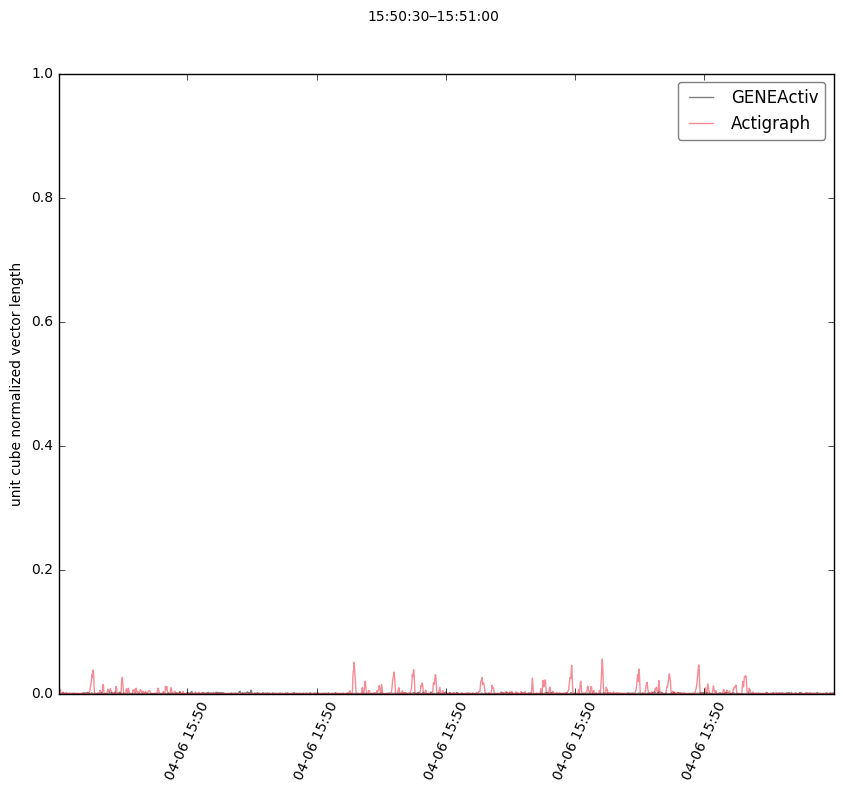

Plotting...
15:51:00–15:51:30


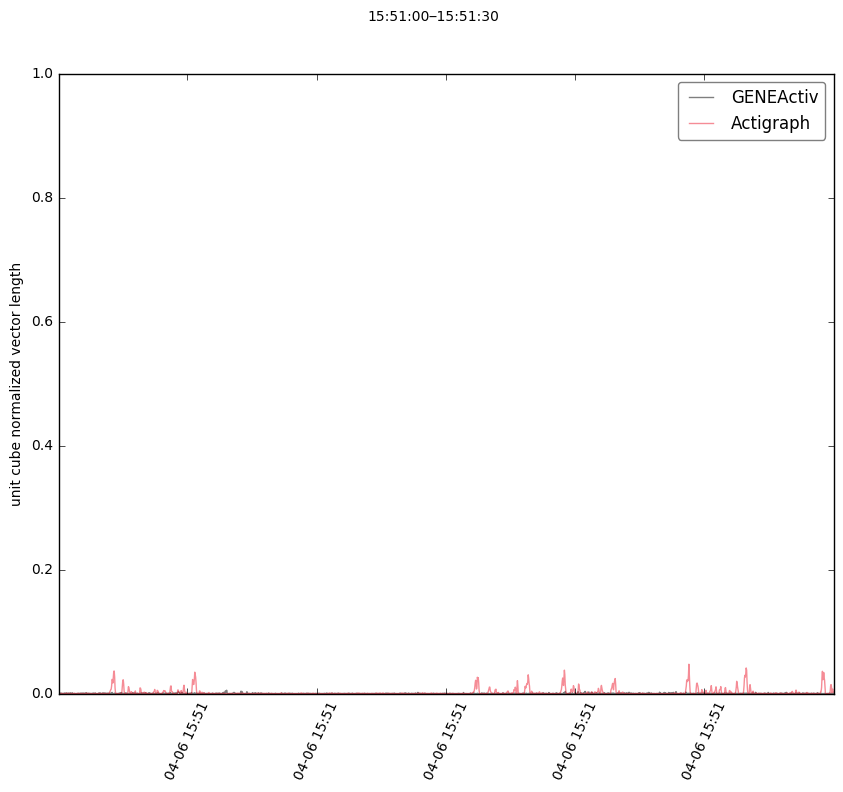

Plotting...
15:51:30–15:52:00


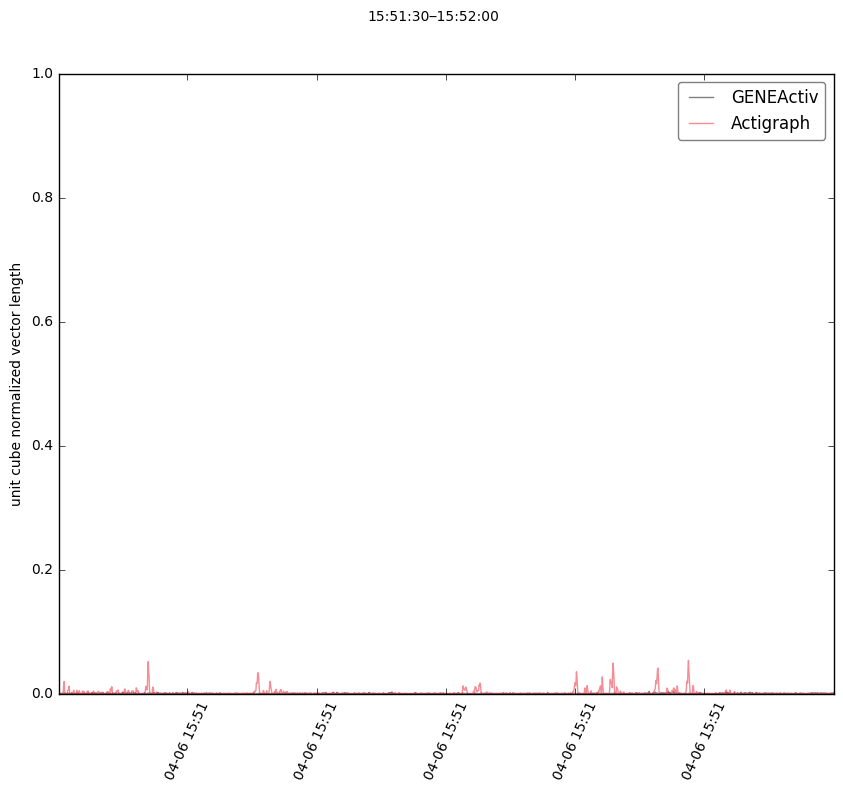

Plotting...
15:52:00–15:52:30


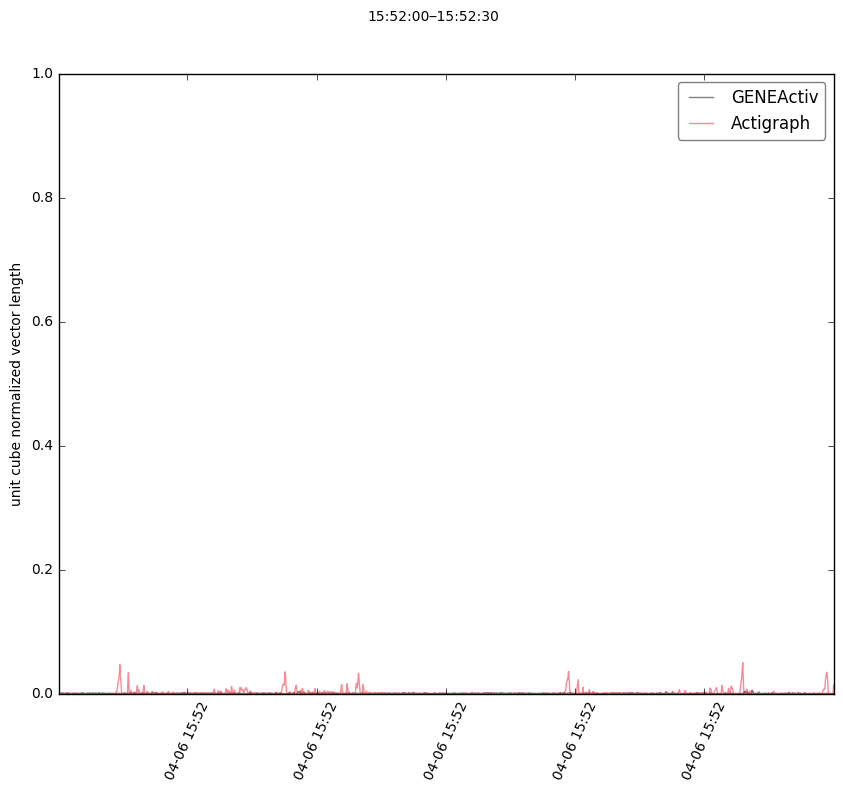

Plotting...
15:52:30–15:53:00


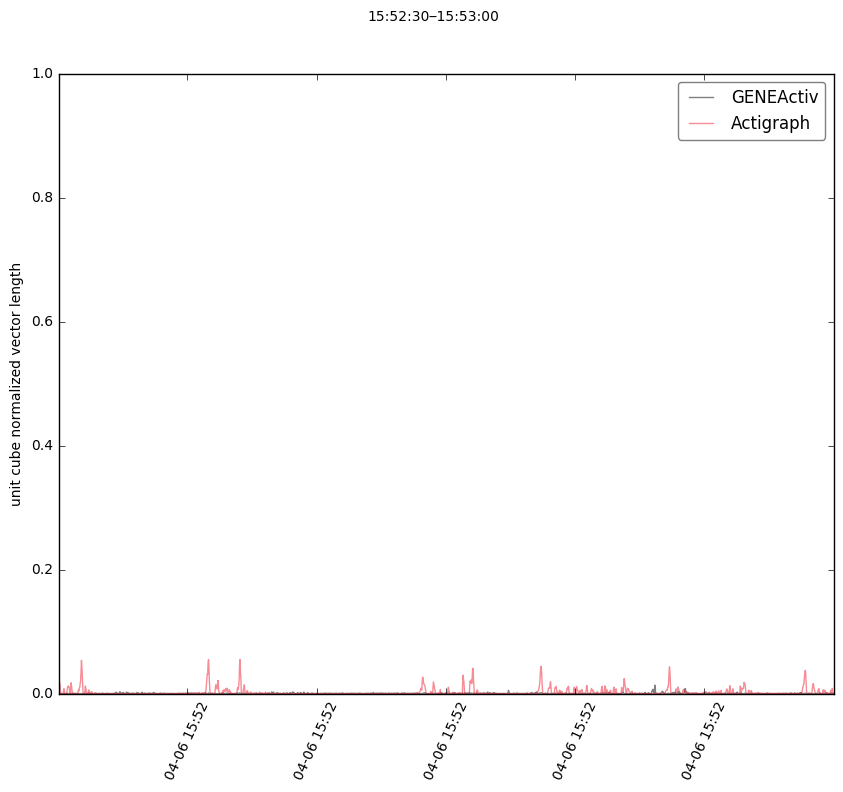

Plotting...
15:53:00–15:53:30


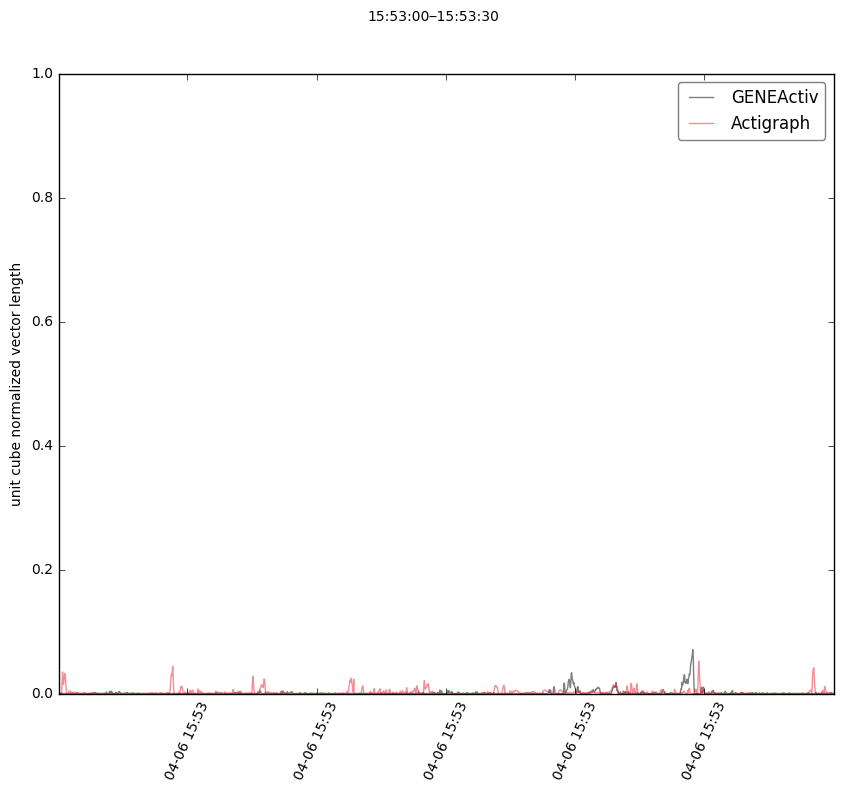

Plotting...
15:53:30–15:54:00


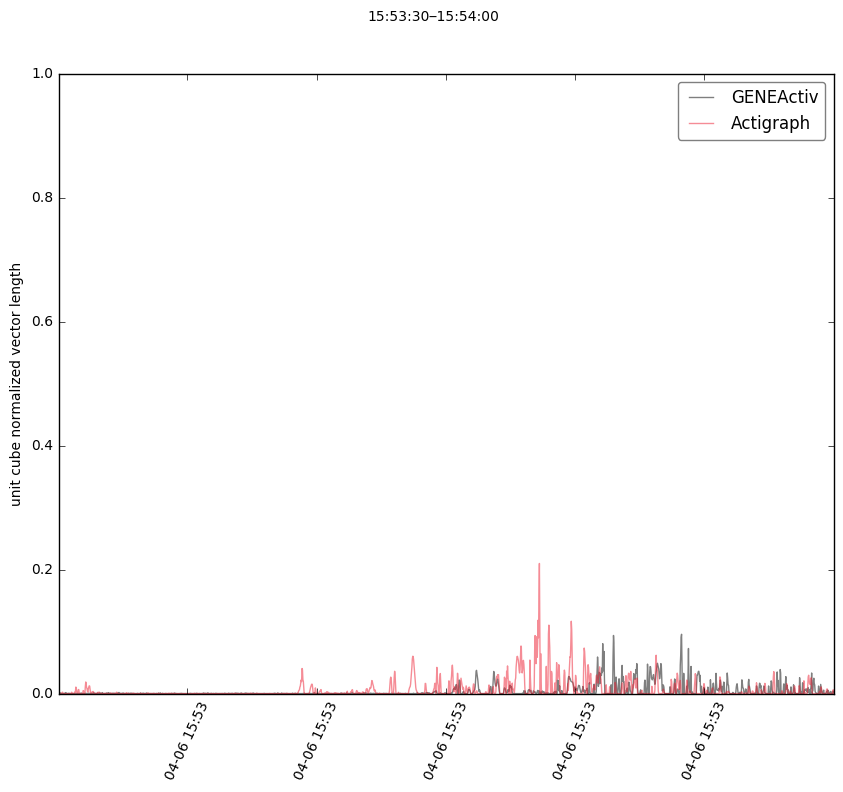

Plotting...
15:54:00–15:54:30


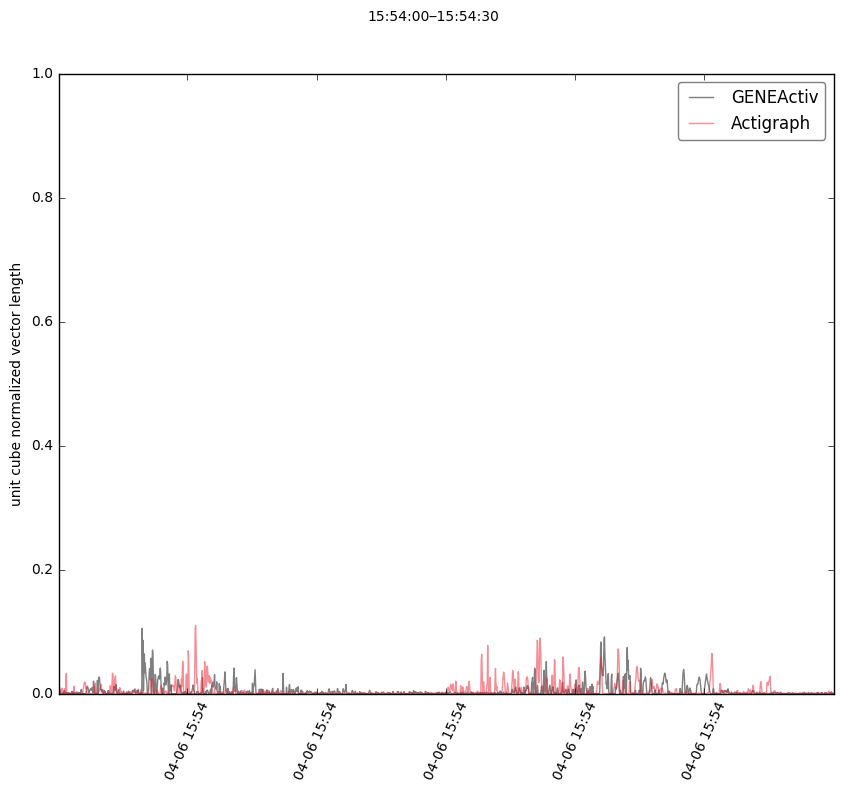

Plotting...
15:54:30–15:55:00


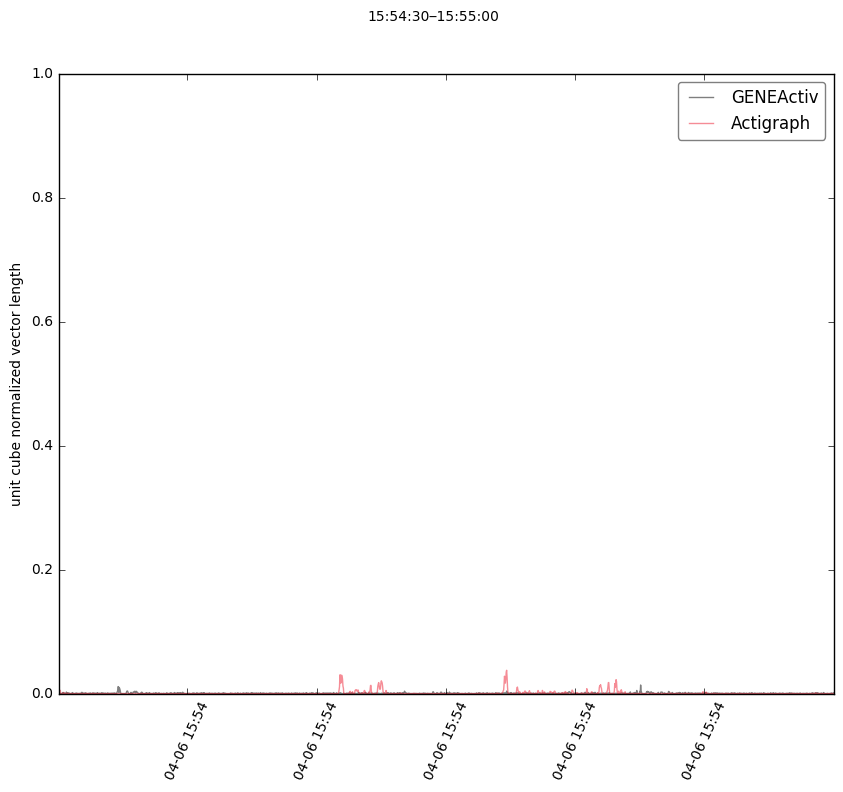

Plotting...
15:55:00–15:55:30


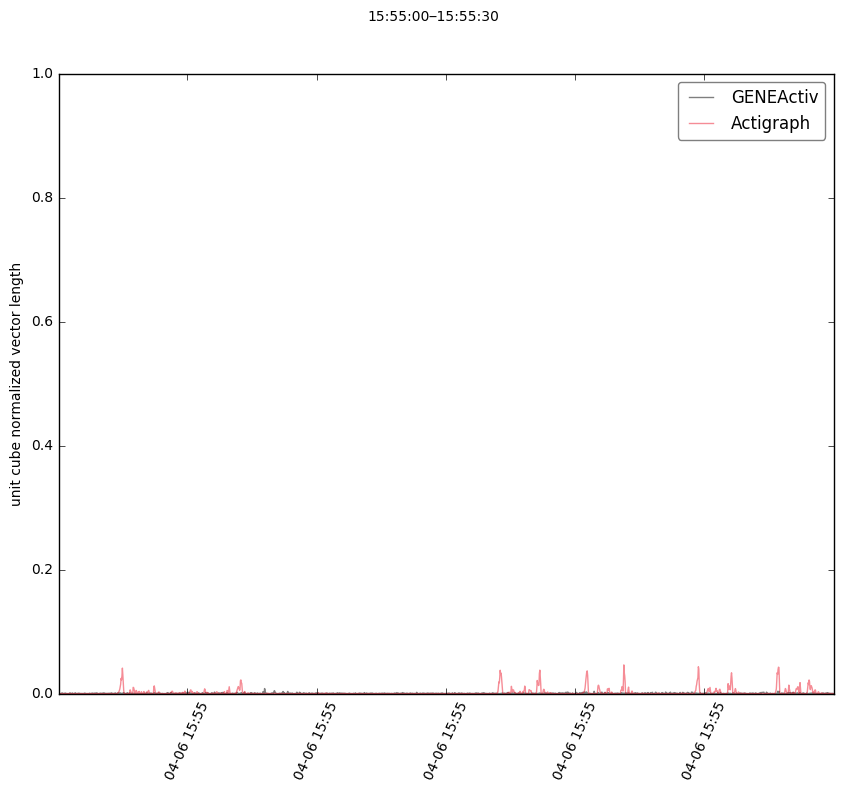

Plotting...
15:55:30–15:56:00


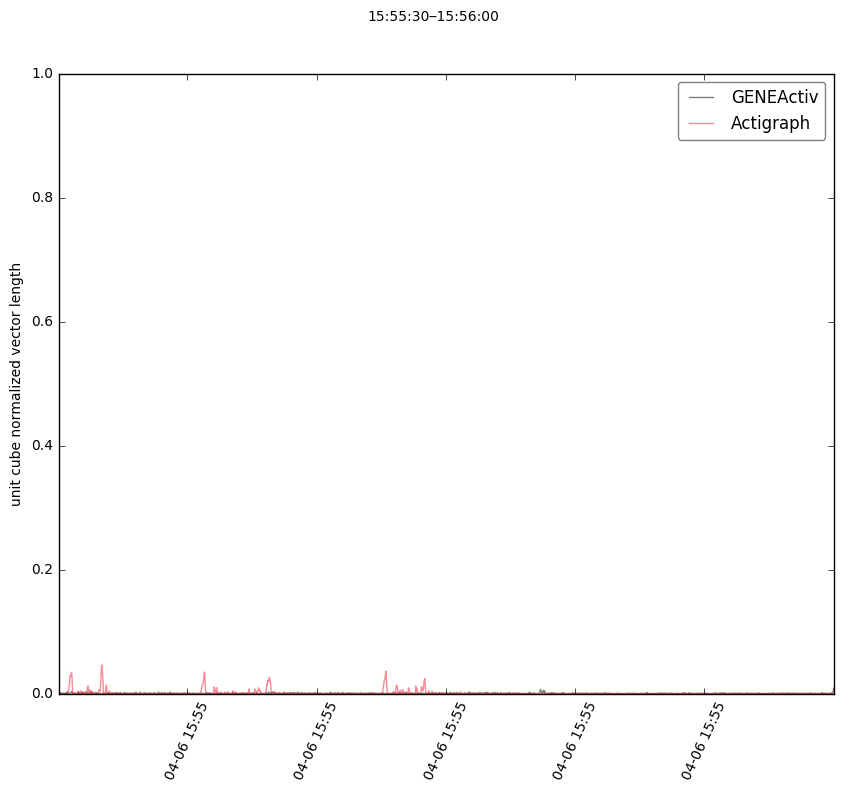

Plotting...
15:56:00–15:56:30


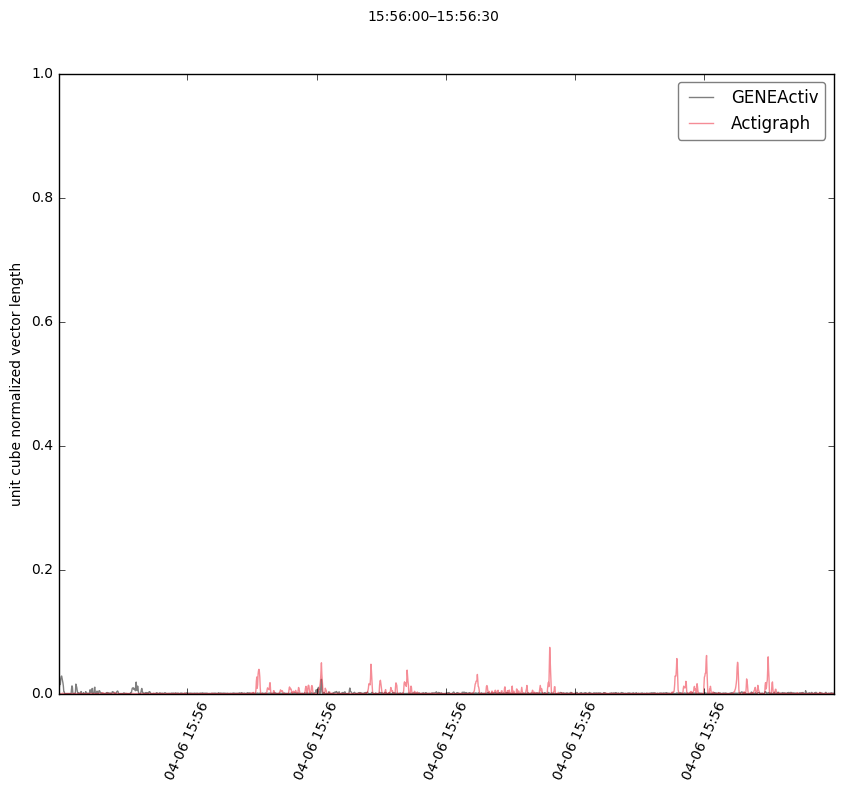

Plotting...
15:56:30–15:57:00


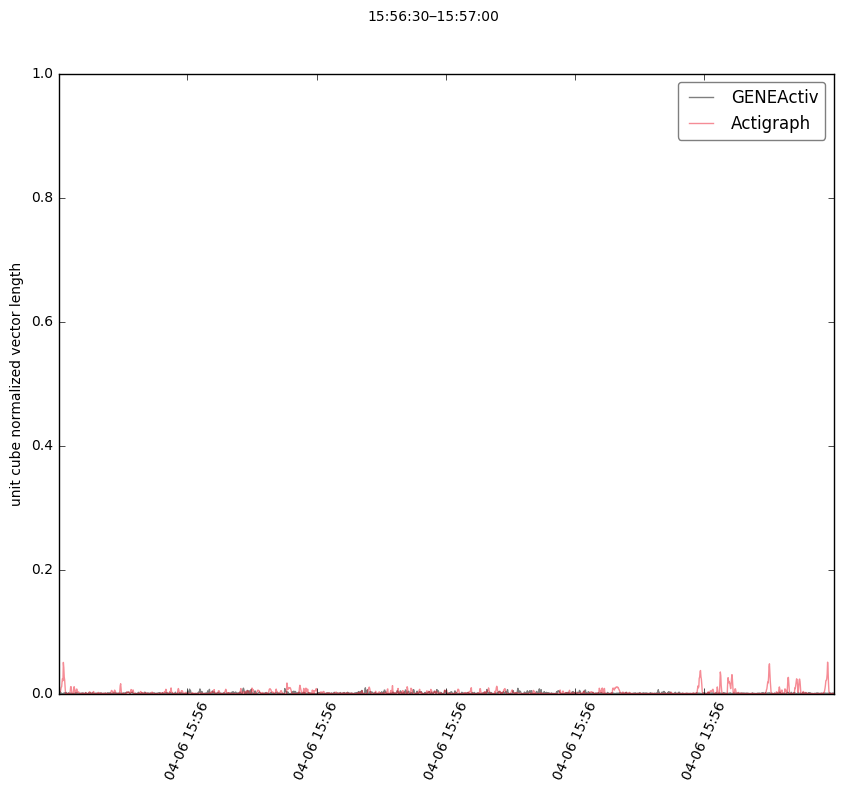

Plotting...
15:57:00–15:57:30


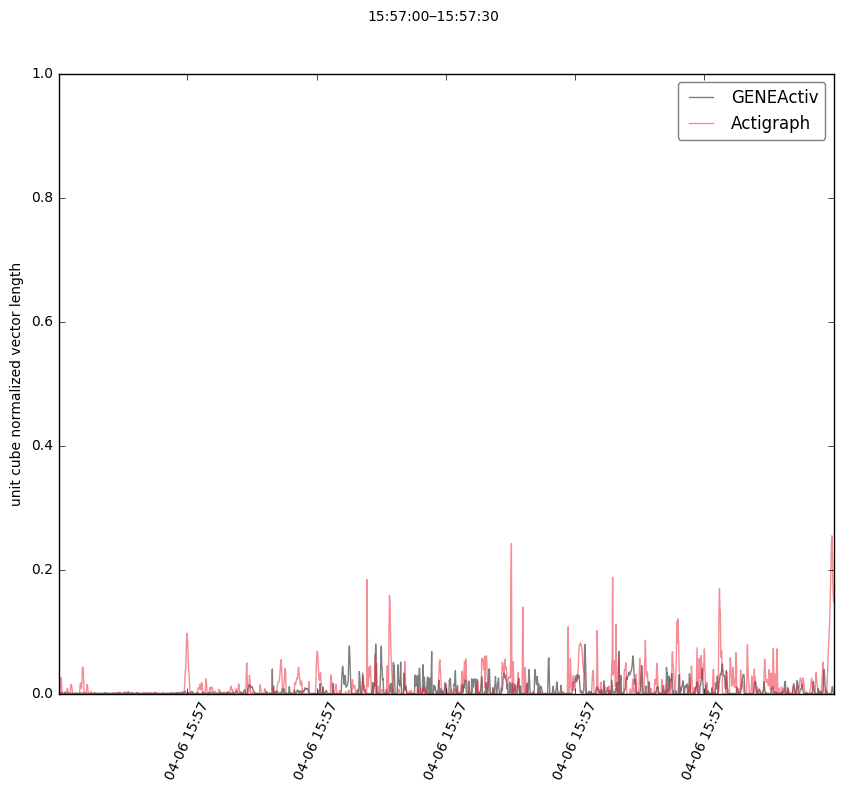

Plotting...
15:57:30–15:58:00


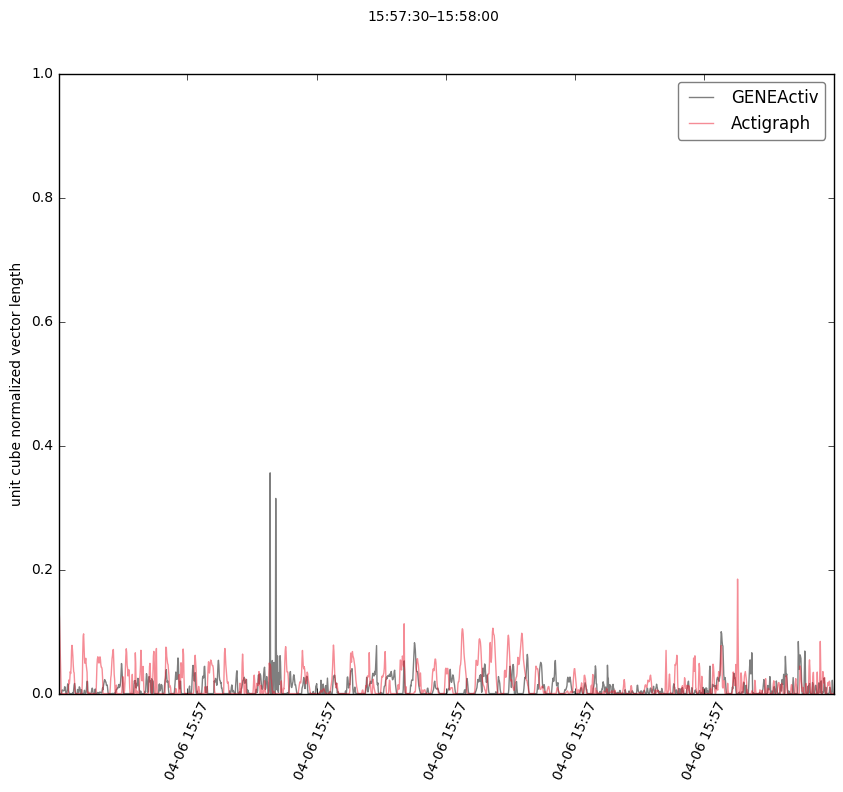

Plotting...
15:58:00–15:58:30


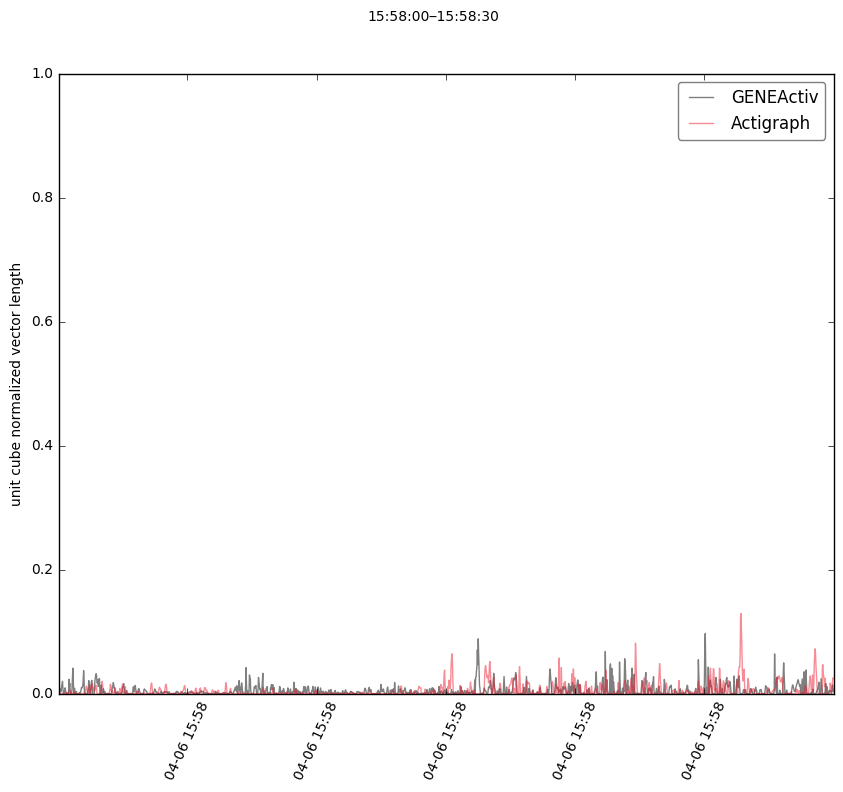

Plotting...
15:58:30–15:59:00


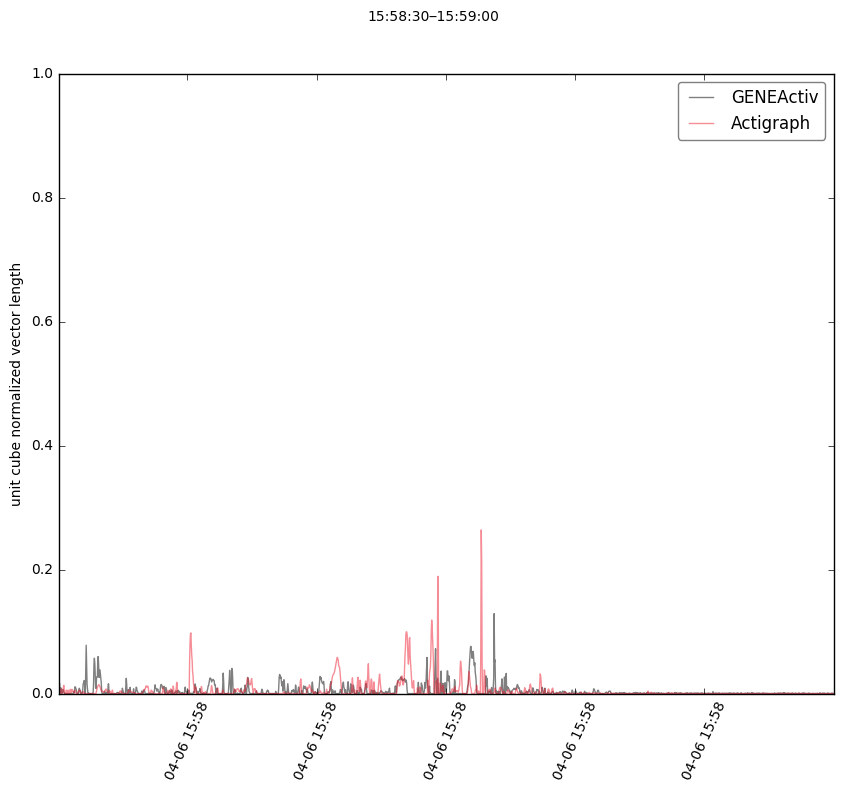

Plotting...
15:59:00–15:59:30


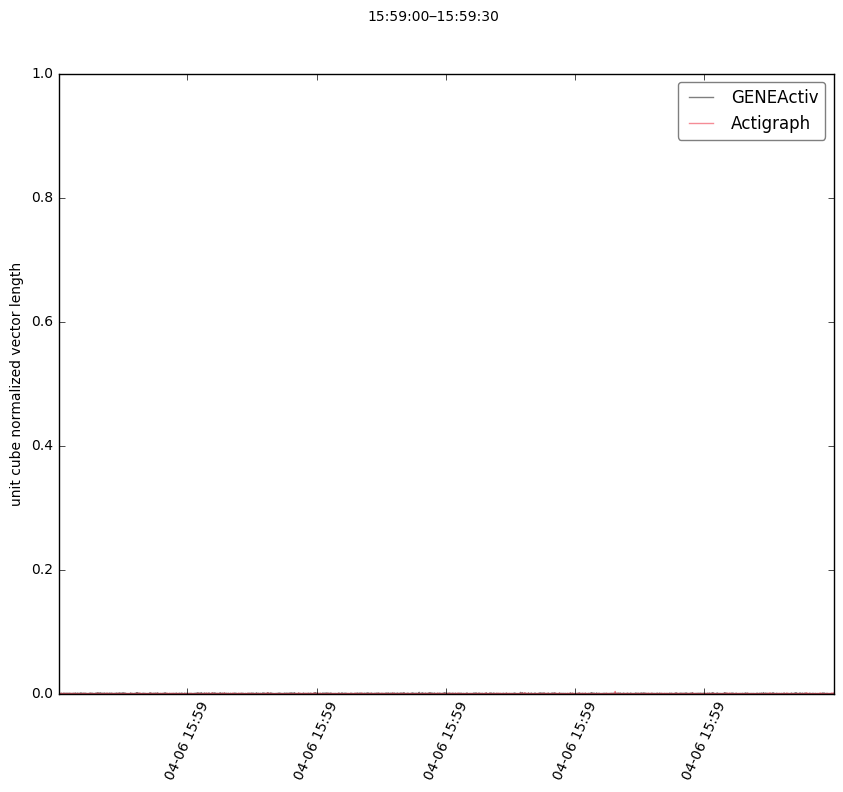

Plotting...
15:59:30–16:00:00


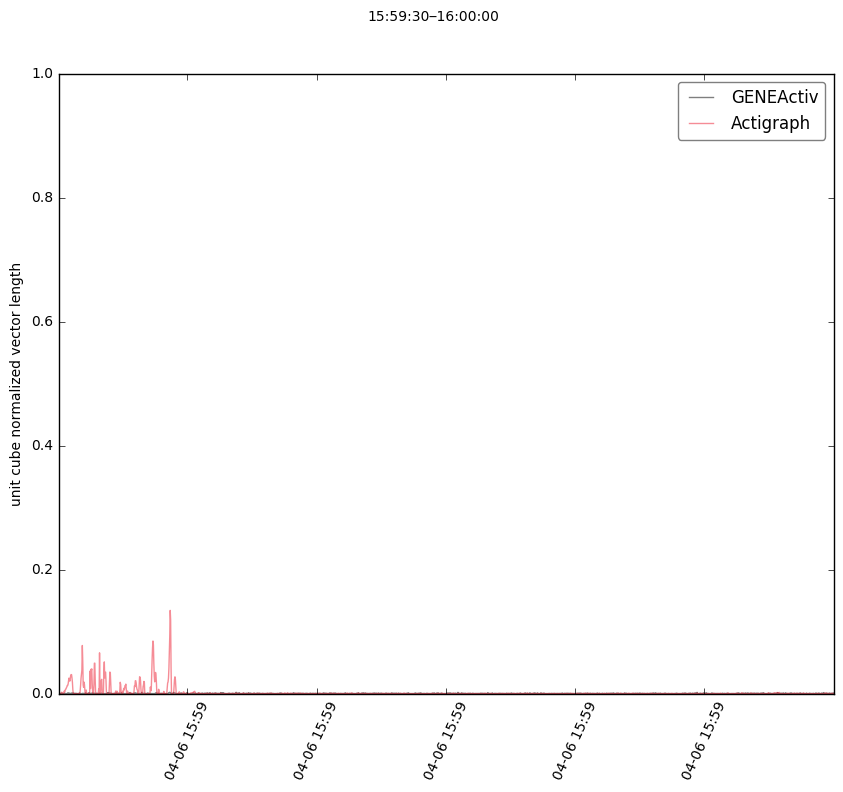

Plotting...
16:00:00–16:00:30


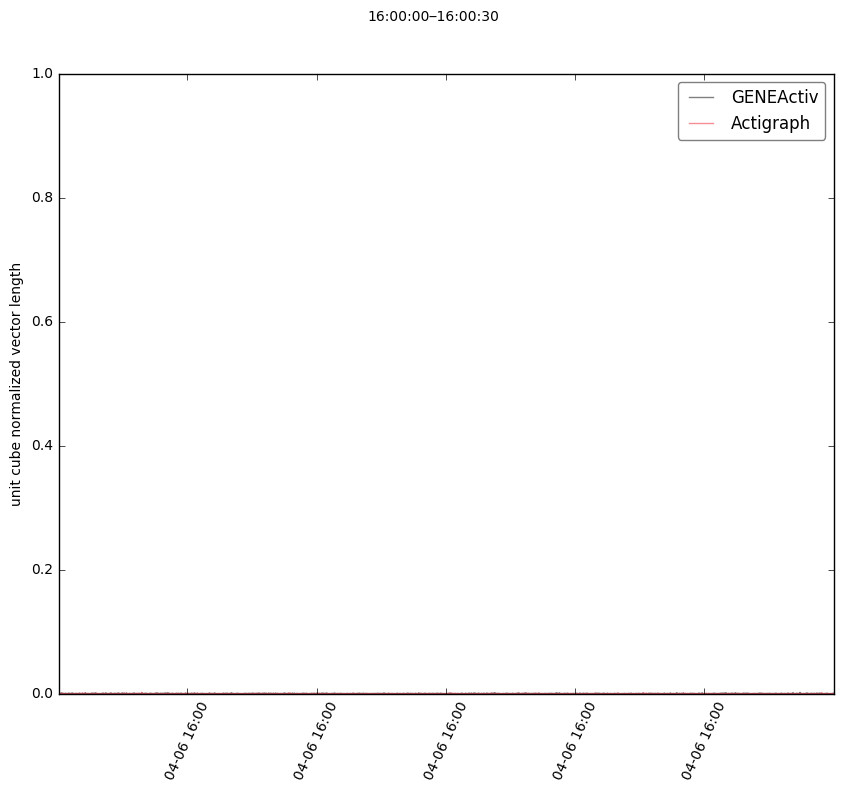

Plotting...
16:00:30–16:01:00


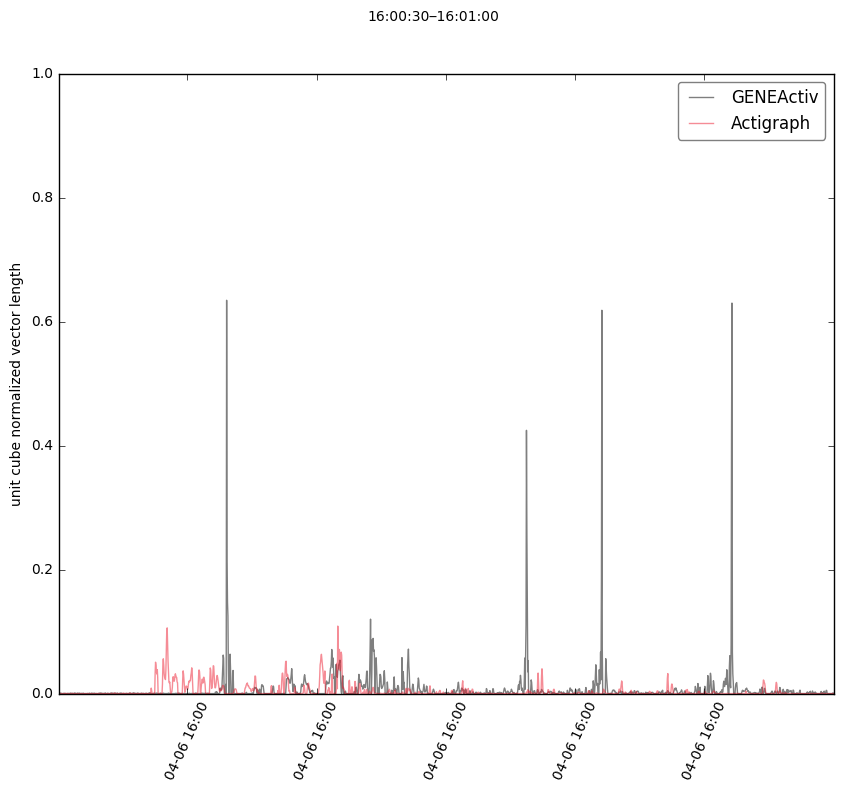

Plotting...
16:01:00–16:01:30


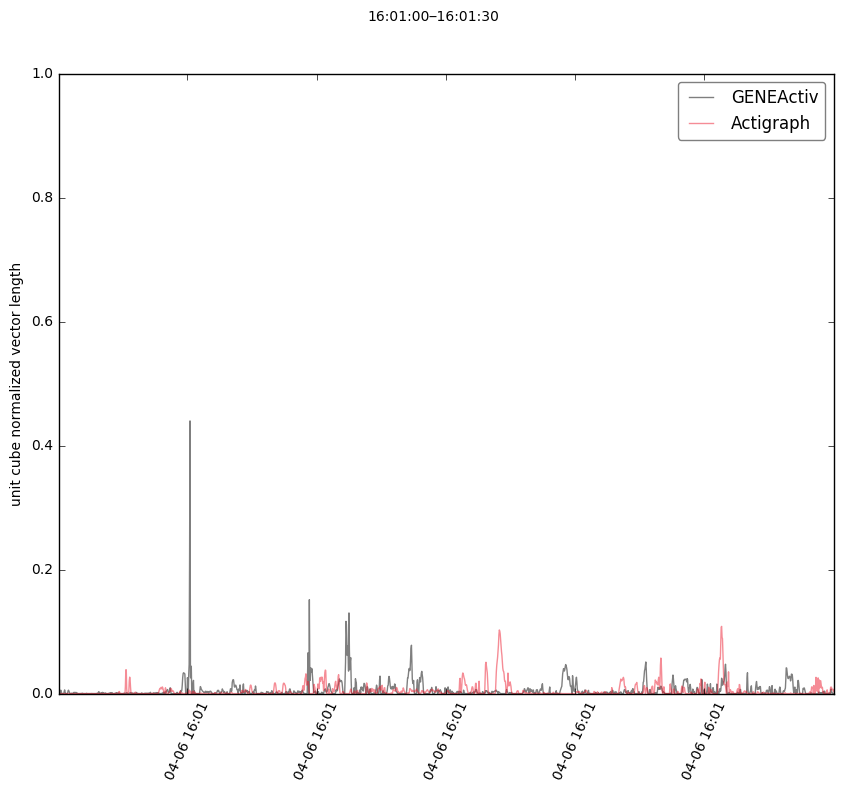

Plotting...
16:01:30–16:02:00


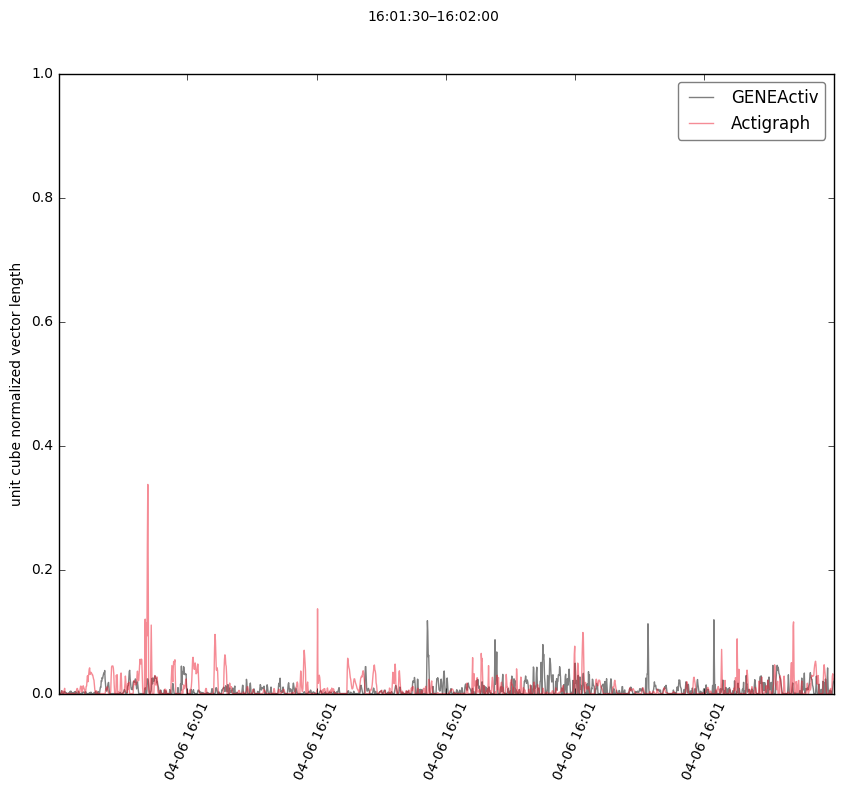

Plotting...
16:02:00–16:02:30


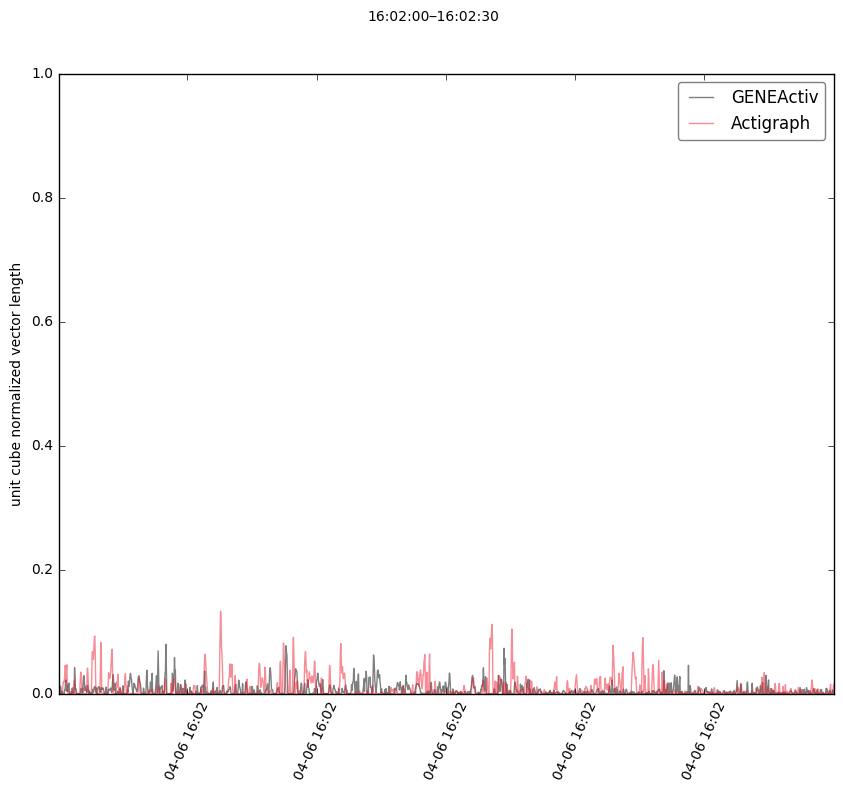

Plotting...
16:02:30–16:03:00


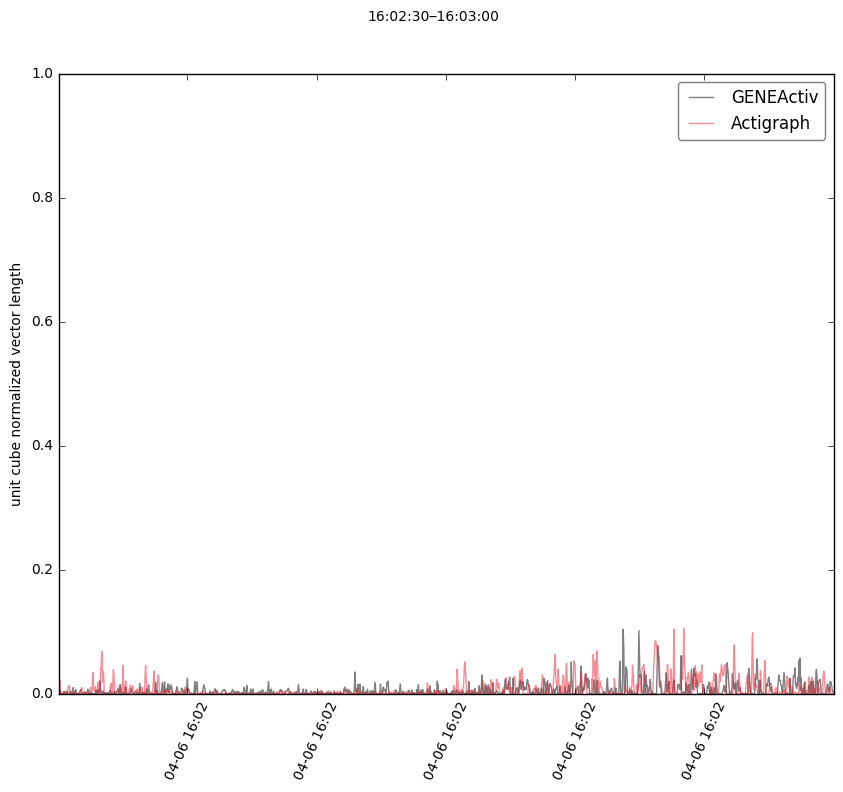

Plotting...
16:03:00–16:03:30


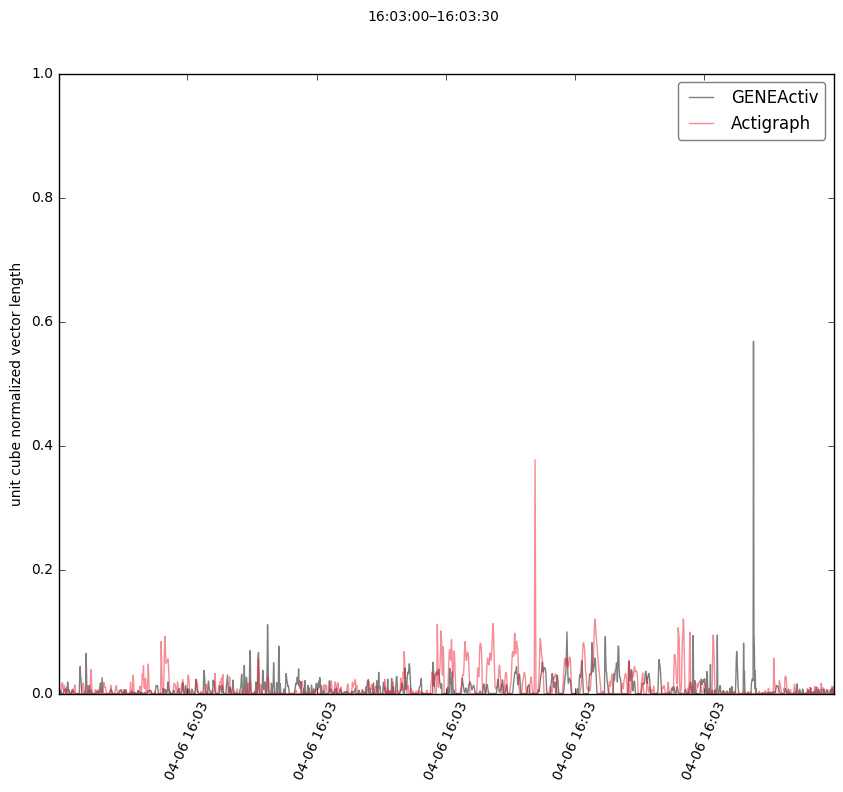

Plotting...
16:03:30–16:04:00


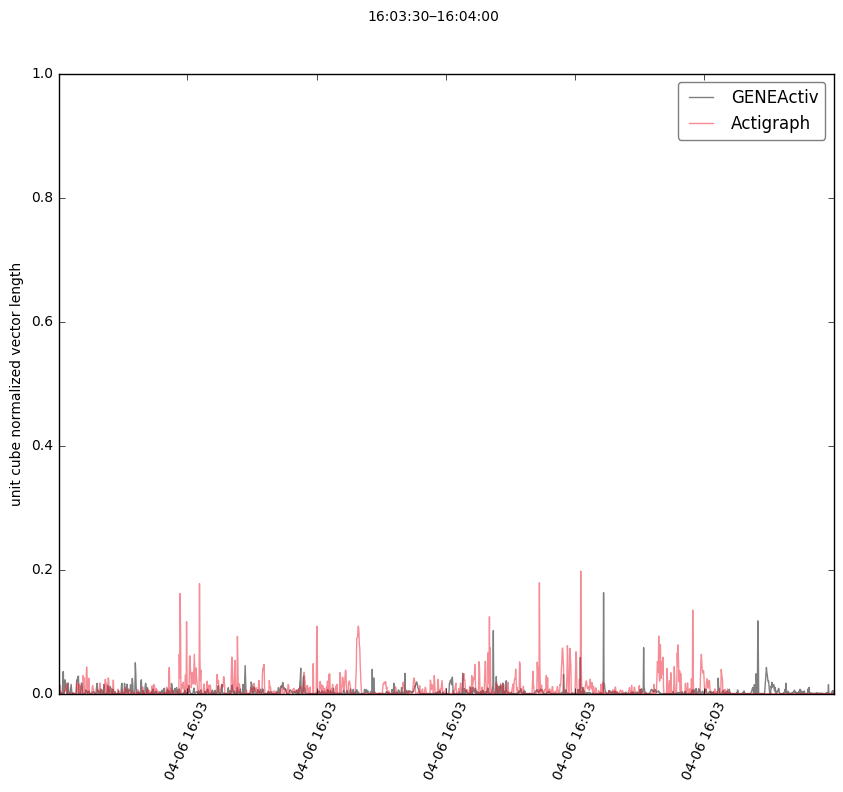

Plotting...
16:04:00–16:04:30


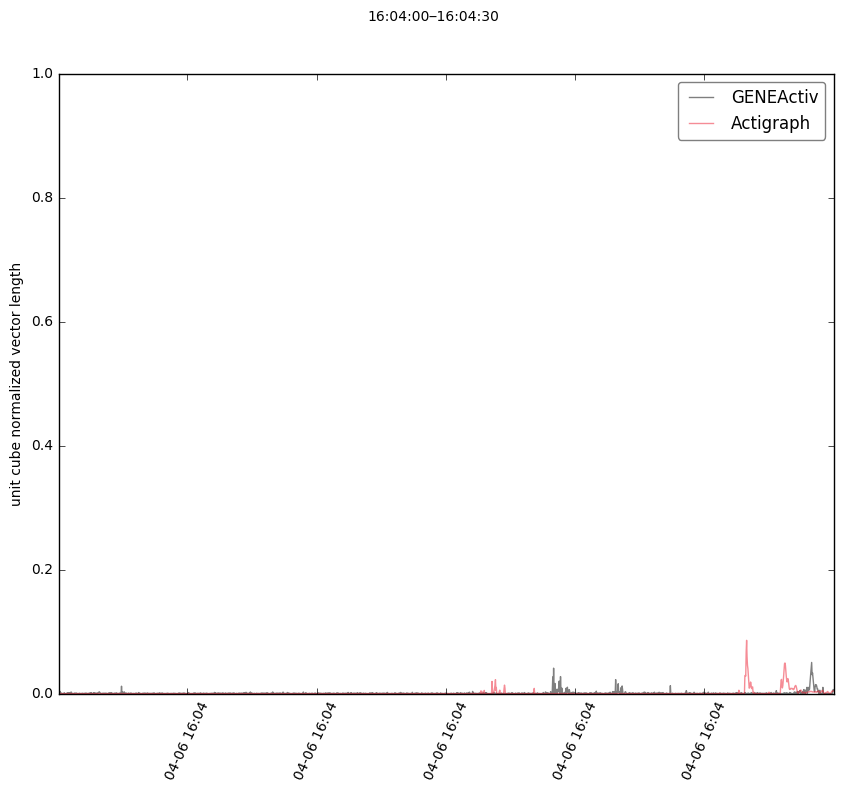

Plotting...
16:04:30–16:05:00


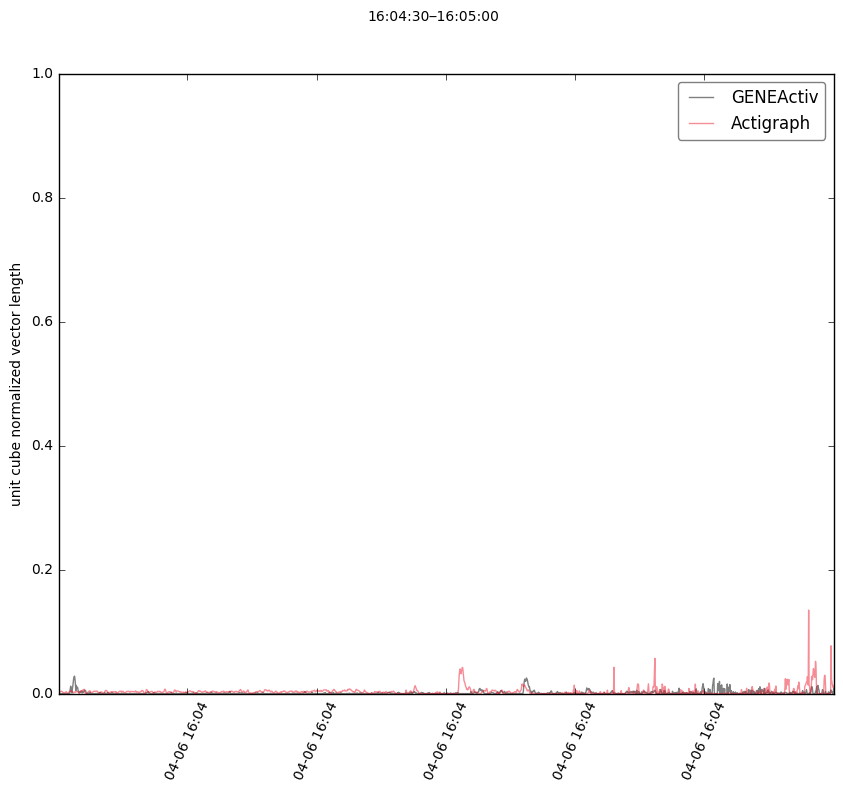

Plotting...
16:05:00–16:05:30


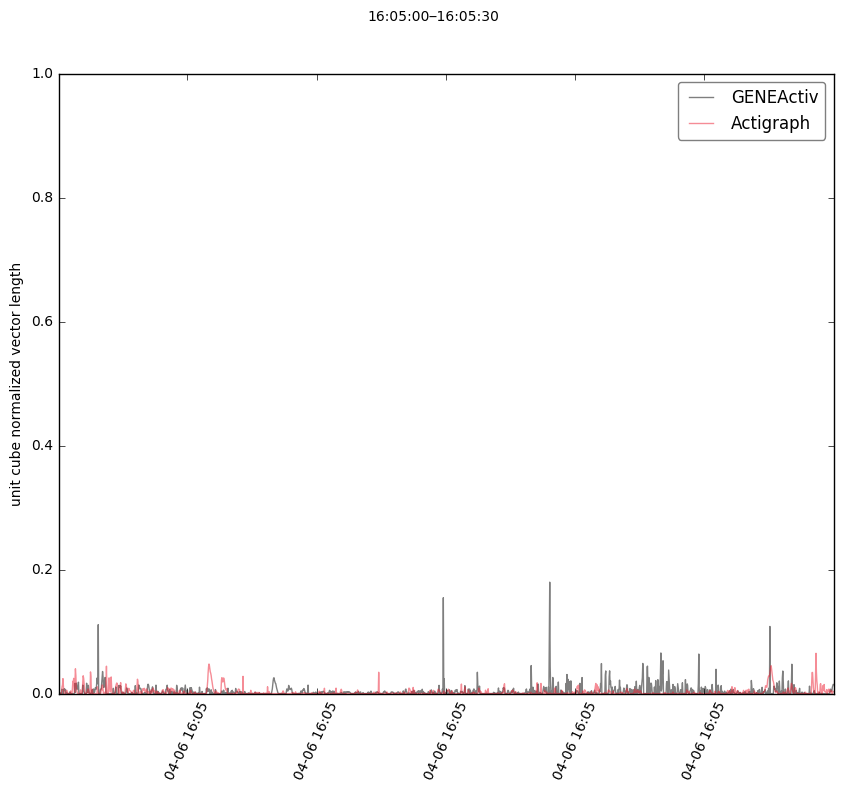

Plotting...
16:05:30–16:06:00


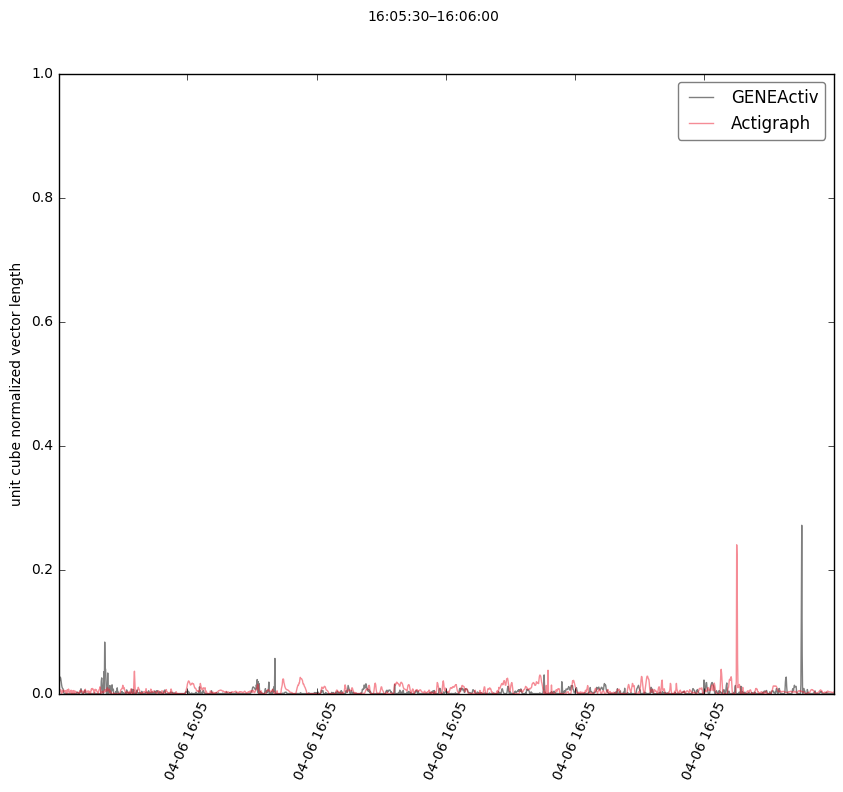

Plotting...
16:06:00–16:06:30


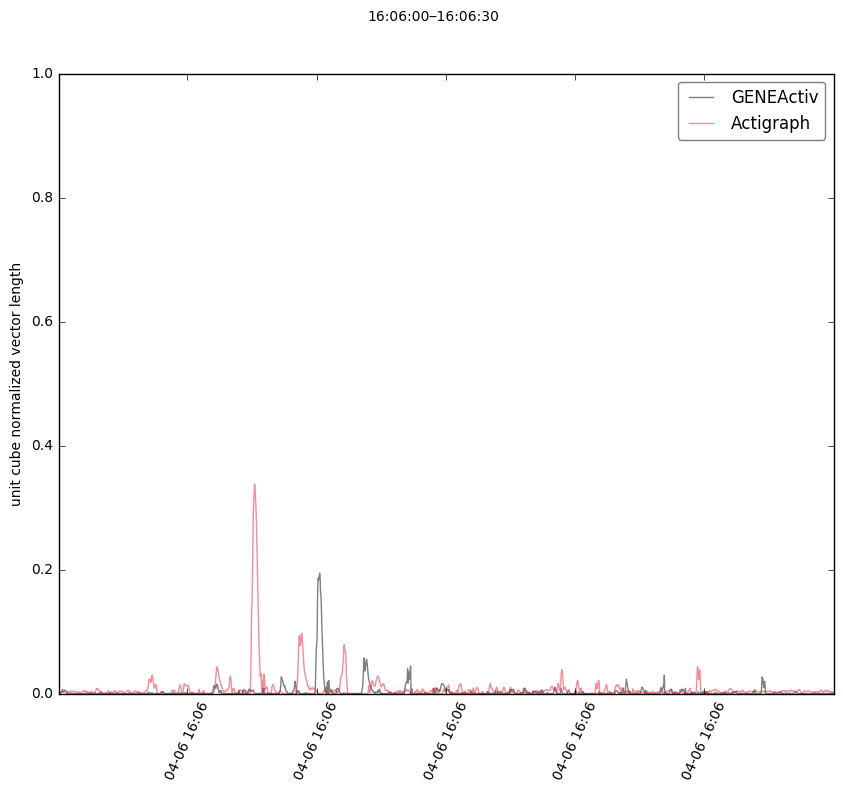

Plotting...
16:06:30–16:07:00


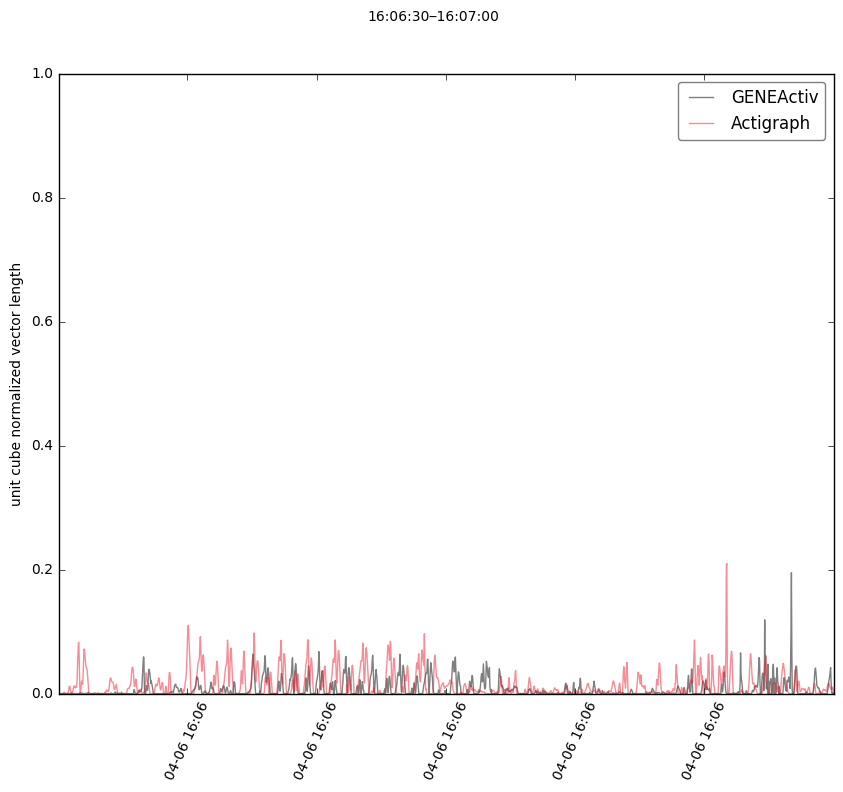

Plotting...
16:07:00–16:07:30


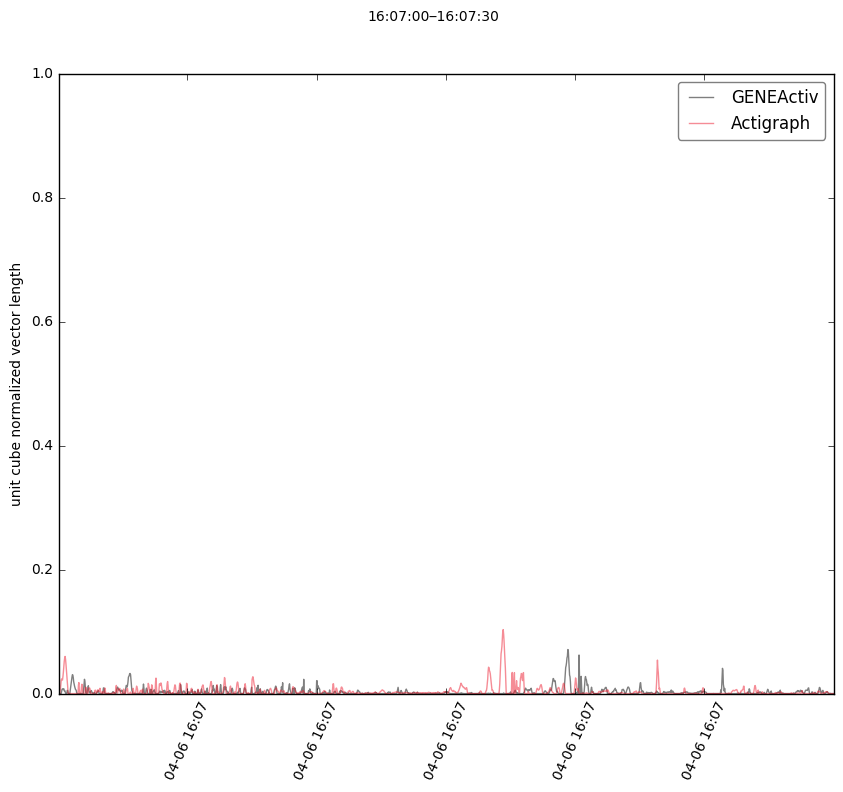

Plotting...
16:07:30–16:08:00


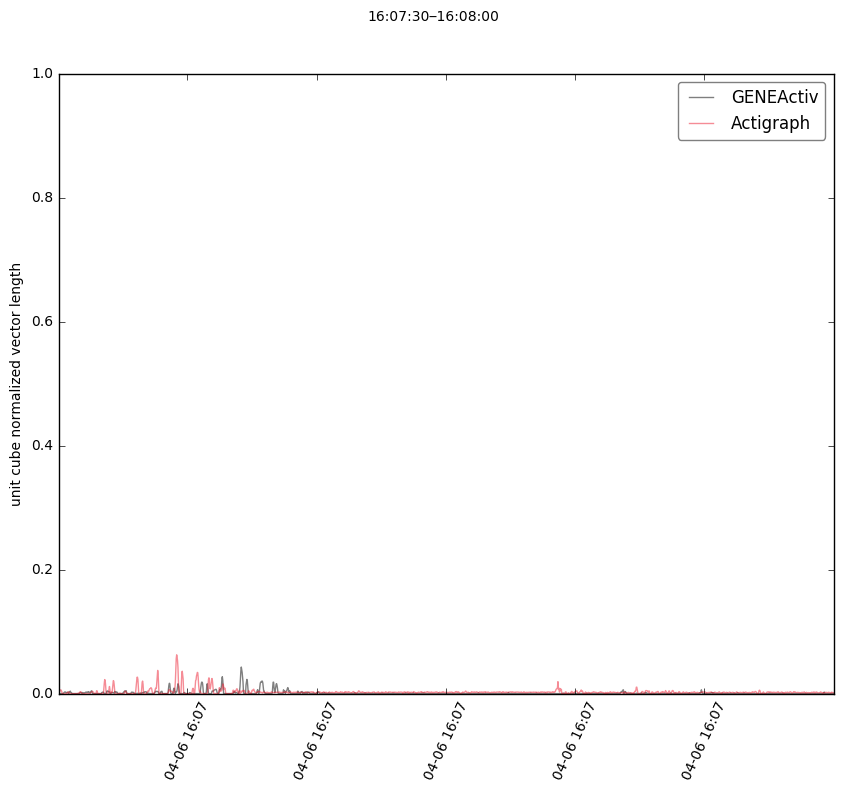

Plotting...
16:08:00–16:08:30


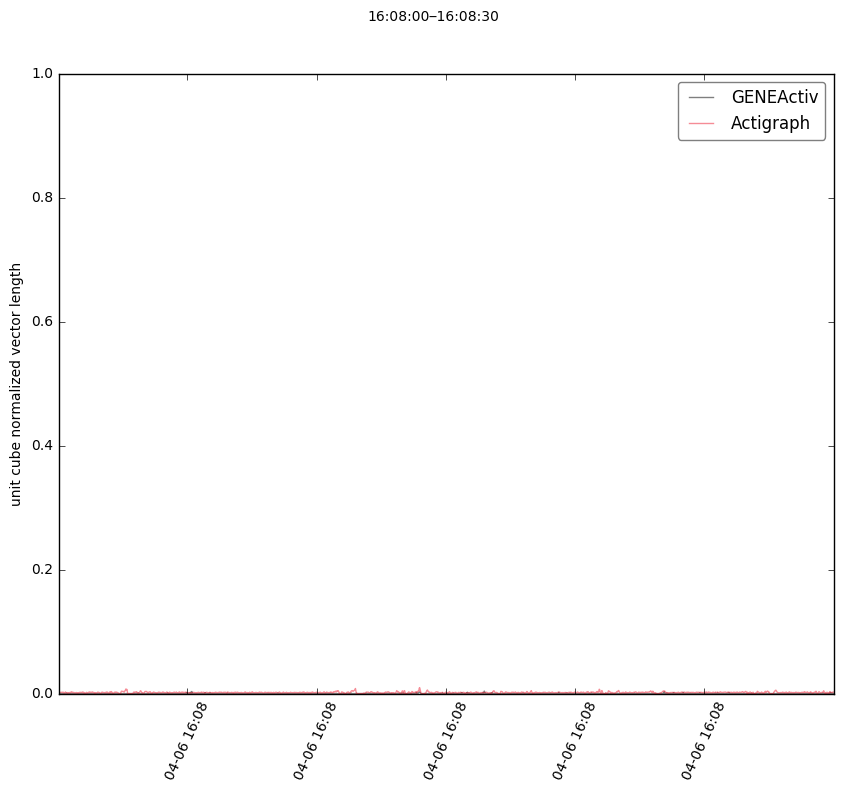

Plotting...
16:08:30–16:09:00


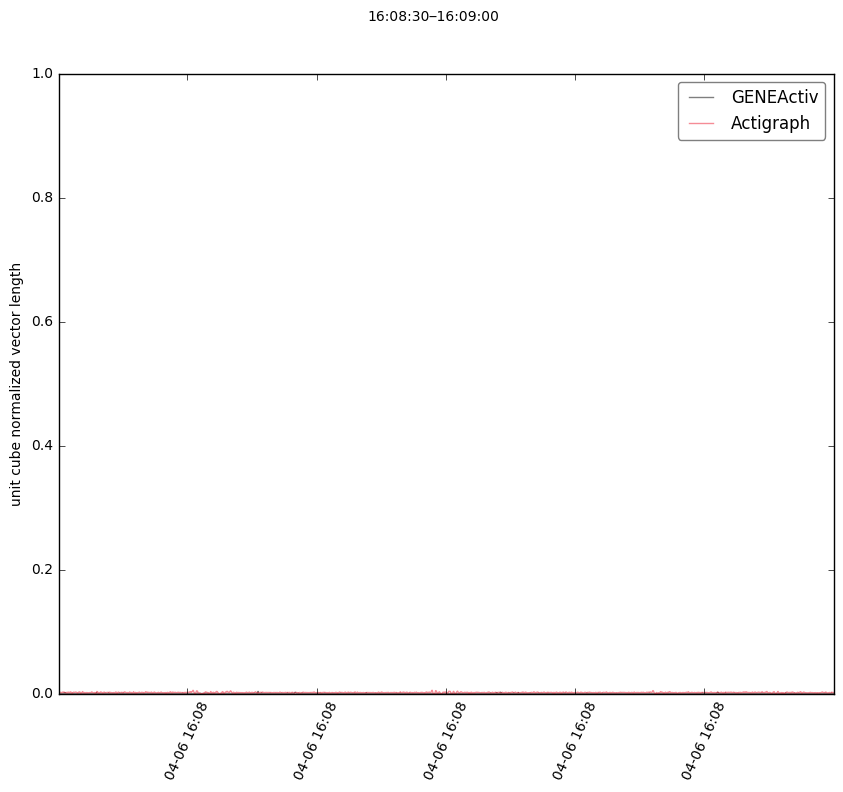

Plotting...
16:09:00–16:09:30


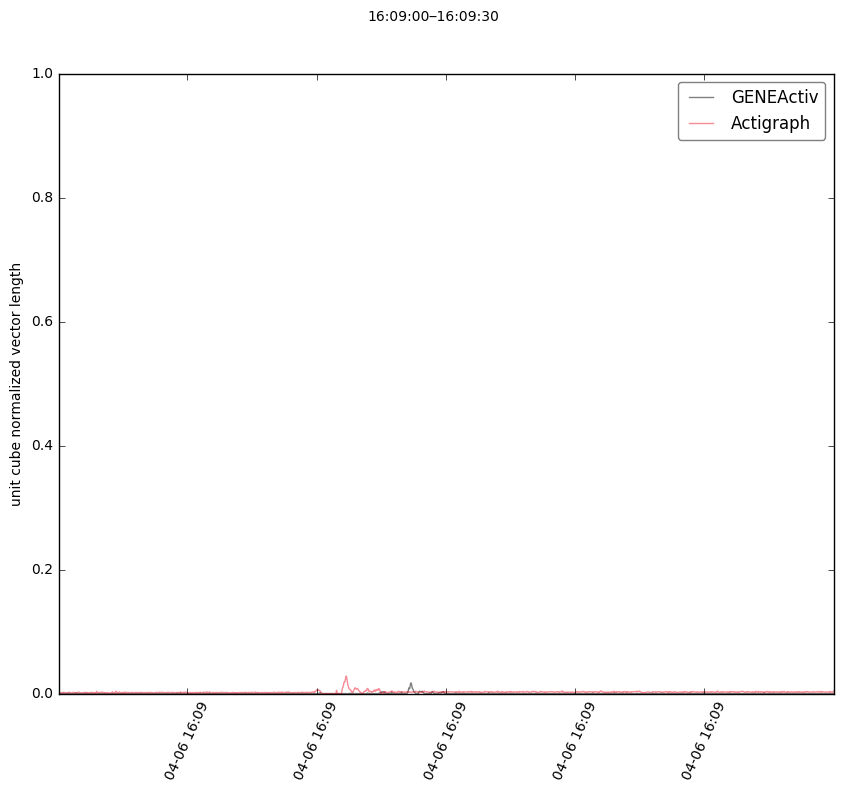

Plotting...
16:09:30–16:10:00


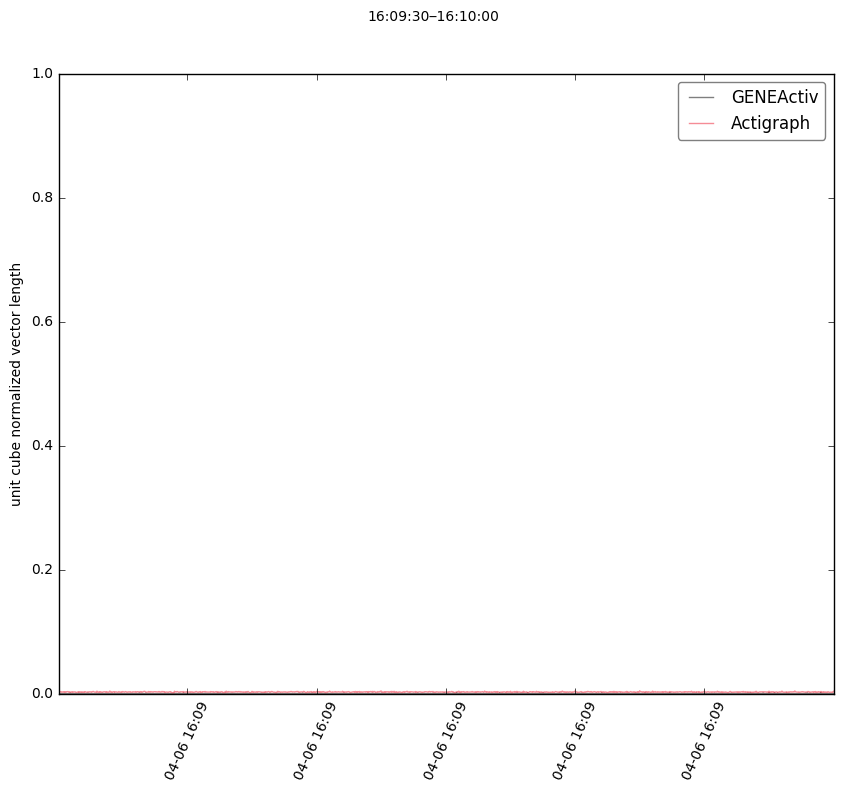

Plotting...
16:10:00–16:10:30


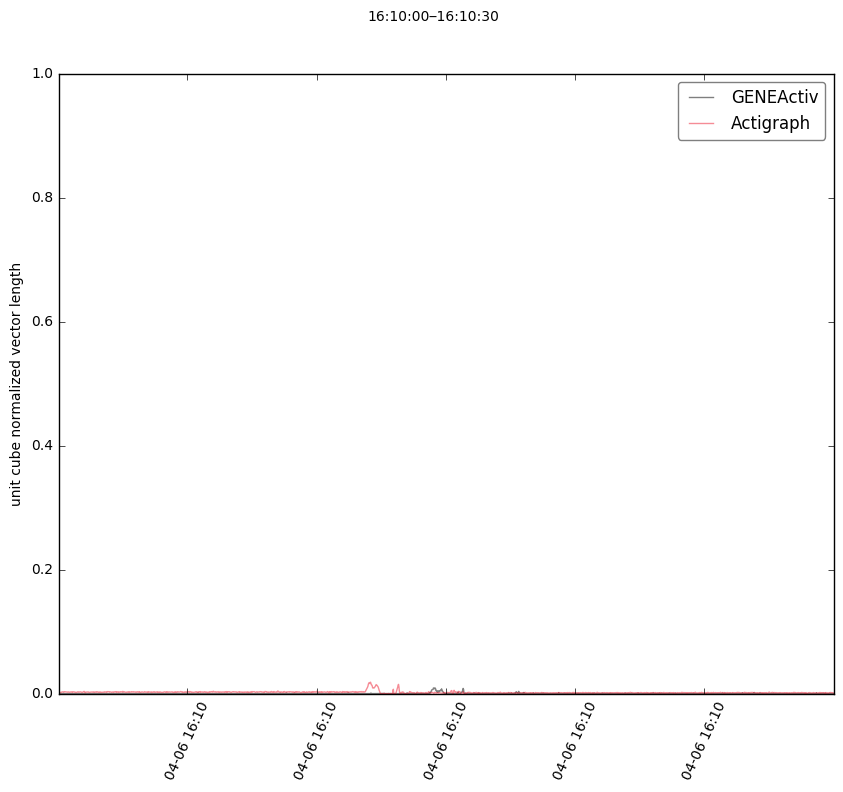

In [ ]:
start = datetime(2017, 4, 6, 15, 45)
stop = datetime(2017, 4, 7, 14, 8)
while start < stop:
    new_start = start + timedelta(seconds=30)
    plot_df = df.loc[(df.index >= start) & (df.index <= new_start)].copy()
    label = '–'.join([start.strftime('%H:%M:%S'), new_start.strftime('%H:%M:%S')])
    linechart(plot_df, label, "Arno")
    start = new_start

In [59]:
no_outliers = df.copy()
print(len(no_outliers))
for column in list(no_outliers.columns):
    truths = (np.abs(no_outliers[[column]] - no_outliers[[column]].mean()) <= (3 * no_outliers[[column]].std()))
    no_outliers[[column]] = no_outliers[[column]][truths]
no_outliers.dropna(how='any', inplace=True)
print(len(no_outliers))

4779754
4653940


In [60]:
pdcorr = no_outliers.corr(method='pearson')
print(pdcorr)

                                         normalized_vector_length_GENEActiv_pink  \
normalized_vector_length_GENEActiv_pink                                 1.000000   
normalized_vector_length_Actigraph                                      0.160953   

                                         normalized_vector_length_Actigraph  
normalized_vector_length_GENEActiv_pink                            0.160953  
normalized_vector_length_Actigraph                                 1.000000  
